# Treinamento de um modelo de classificação de satisfação de clientes em voos de avião


Responsáveis pelas tarefas:
- [X] **Análise Exploratória de Dados e Preprocessamento**: Leo
- [X] **Modelagem, Pipelines e Configuração de Avaliação**: Juan
- [X] **Testes de Modelos, Tuning de Hiperparâmetros e Métricas**: Robson

## Importando as bibliotecas necessárias e fazendo configurações iniciais

In [1]:
import polars as pl
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

import joblib

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from IPython.display import display
from IPython.core.display import HTML

In [2]:
# Configurar para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# Configurar para mostrar todas as linhas
pd.set_option('display.max_rows', None)

# Configurar largura máxima de cada coluna
pd.set_option('display.max_colwidth', None)

# Ajustar a largura da saída no Jupyter Notebook
display(HTML("<style>.container { width:100% !important; }</style>"))

### Funções de Apoio para tratamento de dados

In [3]:
# Função para calcular a correlação para colunas numéricas
def calcular_correlacao(X, y):
    correlacoes = X.corrwith(y)
    print("Correlação com y:")
    print(correlacoes.sort_values(ascending=False))
    return correlacoes

# Função para calcular a importância de colunas categóricas usando teste qui-quadrado
def calcular_importancia_categorica(X, y):
    chi_scores, p_values = chi2(X, y)
    return pd.DataFrame(
        {'Feature': X.columns, 'Chi2': chi_scores, 'p-value': p_values}
    ).sort_values(by='Chi2', ascending=False)

def update_column_names_and_values(df):
    df = df.rename(columns={
        'Gender': 'Genero',
        'Customer Type': 'Tipo_Cliente',
        'Age': 'Idade',
        'Type of Travel': 'Tipo_Viagem',
        'Class': 'Classe',
        'Flight Distance': 'Distancia_Voo',
        'Inflight wifi service': 'Wifi_Bordo',
        'Departure/Arrival time convenient': 'Horario_Conveniente',
        'Ease of Online booking': 'Facilidade_Reserva_Online',
        'Gate location': 'Localizacao_Portao',
        'Food and drink': 'Comida_Bebida',
        'Online boarding': 'Embarque_Online',
        'Seat comfort': 'Conforto_Assento',
        'Inflight entertainment': 'Entretenimento_Bordo',
        'On-board service': 'Servico_Bordo',
        'Leg room service': 'Espaco_Pernas',
        'Baggage handling': 'Manuseio_Bagagem',
        'Checkin service': 'Servico_Checkin',
        'Inflight service': 'Servico_Bordo_Geral',
        'Cleanliness': 'Limpeza',
        'Departure Delay in Minutes': 'Atraso_Partida_Min',
        'Arrival Delay in Minutes': 'Atraso_Chegada_Min',
        'satisfaction': 'Satisfacao'
    })
    
    df['Satisfacao'] = df['Satisfacao'].map({'neutral or dissatisfied': 'Neutro ou Insatisfeito', 'satisfied': 'Satisfeito'})  # Transformar os valores de 'y'
    df['Genero'] = df['Genero'].map({'Male': 'Homem', 'Female': 'Mulher'})
    df['Tipo_Cliente'] = df['Tipo_Cliente'].map({'Loyal Customer': 'Cliente_Fiel', 'disloyal Customer': 'Cliente_Nao_Fiel'})
    df['Tipo_Viagem'] = df['Tipo_Viagem'].map({'Business travel': 'Viagem_Negocios', 'Personal Travel': 'Viagem_Pessoal'})
    df['Classe'] = df['Classe'].map({'Business': 'Executivo', 'Eco Plus': 'Economica_Plus', 'Eco': 'Economica'})
    return df

def calcular_log_chi2(df:pd.DataFrame):
    # Calcular o log do valor de Chi2
    df['Chi2'] = np.log(df['Chi2'])
    return df

### Funções de Apoio para vizualização e exploração (Treinamento para teste dos dados)

In [4]:
def analisar_nulos(X, y):
    # 1. Identifique as linhas com pelo menos um valor nulo em X
    linhas_nulas_X = X.isnull().any(axis=1)
    # 2. Distribuição de y nas linhas com nulos em X
    y_nulos_X = y[linhas_nulas_X]
    # 3. Total de y por categoria
    total_por_categoria = y.value_counts()
    # 4. Total de y_nulos_X por categoria
    nulos_por_categoria = y_nulos_X.value_counts()
    # 5. Proporção de y_nulos_X em relação ao total da categoria
    proporcao_nulos_categoria = (nulos_por_categoria / total_por_categoria).fillna(0)
    # 6. Proporção de y_nulos_X em relação ao total de todos os y
    proporcao_nulos_total = (nulos_por_categoria / len(y)).fillna(0)

    print("\nProporção de y_nulos_X em relação ao total da categoria:")
    display(proporcao_nulos_categoria)
    print("\nProporção de y_nulos_X em relação ao total de todos os y:")
    display(proporcao_nulos_total)

    if not y_nulos_X.empty:
        df_plot = pd.DataFrame({
            'Proporção na Categoria': proporcao_nulos_categoria,
            'Proporção no Total': proporcao_nulos_total
        }).fillna(0)
        df_plot.plot(kind='bar', figsize=(8,4))
        plt.title('Proporção de y (linhas com nulos em X)')
        plt.ylabel('Proporção')
        plt.show()
    else:
        print("Não há linhas com valores nulos em X.")

def plotar_distribuicao(y, title):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Contagem')
    plt.show()

def plotar_matriz_de_dispersao(X, y, columns):
    sns.pairplot(X[columns].join(y), hue=y.name)
    plt.title('Matriz de Dispersão')
    plt.show()

# Função para plotar colunas numéricas mais relevantes com gráfico de dispersão
def plotar_colunas(X, y, colunas_relevantes, texto_de_print=''):
    print(texto_de_print)
    for col in colunas_relevantes:
        plt.figure(figsize=(8, 4))
        sns.histplot(data=X, x=col, hue=y, kde=True, bins=30, palette="viridis", element="step")
        plt.title(f'Distribuição de {col} em relação a y')
        plt.xlabel(col)
        plt.ylabel('Frequência')
        plt.show()
    return None

# Análise inicial do dataset
def analisando_dados_do_dataset(df):
    print('\n[INFO] Informações do DataFrame:')
    display(df.info())
    print('\n[HEAD] Primeiras linhas do DataFrame:')
    display(df.head())
    print('\n[DESCRIBE] Estatísticas descritivas:')
    display(df.describe())
    print('\n[COLUMNS] Nome das colunas:')
    display(df.columns)
    print('\n[NULLS] Quantidade de valores nulos por coluna:')
    display(df.isnull().sum())
    print('\n[DTYPES] Tipos de dados das colunas:')
    display(df.dtypes)
    print('\n[SHAPE] Formato do DataFrame (linhas, colunas):')
    display(df.shape)
    print('\n[MEMORY USAGE] Uso de memória:')
    display(df.memory_usage(deep=True))
    print('\n[ANÁLISE DE NULOS]')
    analisar_nulos(df.drop(columns=['Satisfacao']), df['Satisfacao'])
    print('\n[DISTRIBUIÇÃO DE CLASSES]')
    plotar_distribuicao(df['Satisfacao'], 'Distribuição de Classes')
    

## Fluxo Manual (Sem Pipeline)

### Fazendo importação do dataset

In [5]:
df_polars = pl.read_csv('fly_satisfaction.csv')

# Converter para PyArrow Table
arrow_table = df_polars.to_arrow()

# Converter para Pandas DataFrame
df = pd.DataFrame(arrow_table.to_pydict())
df = update_column_names_and_values(df)

# Verificar o DataFrame
display(df.head())

,Genero,Tipo_Cliente,Idade,Tipo_Viagem,Classe,Distancia_Voo,Wifi_Bordo,Horario_Conveniente,Facilidade_Reserva_Online,Localizacao_Portao,Comida_Bebida,Embarque_Online,Conforto_Assento,Entretenimento_Bordo,Servico_Bordo,Espaco_Pernas,Manuseio_Bagagem,Servico_Checkin,Servico_Bordo_Geral,Limpeza,Atraso_Partida_Min,Atraso_Chegada_Min,Satisfacao
0,Homem,Cliente_Nao_Fiel,48,Viagem_Negocios,Executivo,821,3,3,3,3,5,3,5,5,3,2,5,4,5,5,2,5.0,Neutro ou Insatisfeito
1,Mulher,Cliente_Fiel,35,Viagem_Negocios,Executivo,821,2,2,2,2,3,5,4,5,5,5,5,3,5,5,26,39.0,Satisfeito
2,Homem,Cliente_Fiel,41,Viagem_Negocios,Executivo,853,4,4,4,4,5,5,5,3,3,3,3,4,3,5,0,0.0,Satisfeito
3,Homem,Cliente_Fiel,50,Viagem_Negocios,Executivo,1905,2,2,2,2,4,4,5,5,5,5,5,3,5,4,0,0.0,Satisfeito
4,Mulher,Cliente_Fiel,49,Viagem_Negocios,Executivo,3470,3,3,3,3,4,5,4,3,3,4,3,3,3,5,0,1.0,Satisfeito


### Analidando os dados do dataset


[INFO] Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Genero                     129880 non-null  object 
 1   Tipo_Cliente               129880 non-null  object 
 2   Idade                      129880 non-null  int64  
 3   Tipo_Viagem                129880 non-null  object 
 4   Classe                     129880 non-null  object 
 5   Distancia_Voo              129880 non-null  int64  
 6   Wifi_Bordo                 129880 non-null  int64  
 7   Horario_Conveniente        129880 non-null  int64  
 8   Facilidade_Reserva_Online  129880 non-null  int64  
 9   Localizacao_Portao         129880 non-null  int64  
 10  Comida_Bebida              129880 non-null  int64  
 11  Embarque_Online            129880 non-null  int64  
 12  Conforto_Assento           129880 non-null  int64  


None


[HEAD] Primeiras linhas do DataFrame:


,Genero,Tipo_Cliente,Idade,Tipo_Viagem,Classe,Distancia_Voo,Wifi_Bordo,Horario_Conveniente,Facilidade_Reserva_Online,Localizacao_Portao,Comida_Bebida,Embarque_Online,Conforto_Assento,Entretenimento_Bordo,Servico_Bordo,Espaco_Pernas,Manuseio_Bagagem,Servico_Checkin,Servico_Bordo_Geral,Limpeza,Atraso_Partida_Min,Atraso_Chegada_Min,Satisfacao
0,Homem,Cliente_Nao_Fiel,48,Viagem_Negocios,Executivo,821,3,3,3,3,5,3,5,5,3,2,5,4,5,5,2,5.0,Neutro ou Insatisfeito
1,Mulher,Cliente_Fiel,35,Viagem_Negocios,Executivo,821,2,2,2,2,3,5,4,5,5,5,5,3,5,5,26,39.0,Satisfeito
2,Homem,Cliente_Fiel,41,Viagem_Negocios,Executivo,853,4,4,4,4,5,5,5,3,3,3,3,4,3,5,0,0.0,Satisfeito
3,Homem,Cliente_Fiel,50,Viagem_Negocios,Executivo,1905,2,2,2,2,4,4,5,5,5,5,5,3,5,4,0,0.0,Satisfeito
4,Mulher,Cliente_Fiel,49,Viagem_Negocios,Executivo,3470,3,3,3,3,4,5,4,3,3,4,3,3,3,5,0,1.0,Satisfeito



[DESCRIBE] Estatísticas descritivas:


,Idade,Distancia_Voo,Wifi_Bordo,Horario_Conveniente,Facilidade_Reserva_Online,Localizacao_Portao,Comida_Bebida,Embarque_Online,Conforto_Assento,Entretenimento_Bordo,Servico_Bordo,Espaco_Pernas,Manuseio_Bagagem,Servico_Checkin,Servico_Bordo_Geral,Limpeza,Atraso_Partida_Min,Atraso_Chegada_Min
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,39.427957,1190.316392,2.728696,3.057599,2.756876,2.976925,3.204774,3.252633,3.441361,3.358077,3.383023,3.350878,3.632114,3.306267,3.642193,3.286326,14.713713,15.091129
std,15.119360,997.452477,1.329340,1.526741,1.401740,1.278520,1.329933,1.350719,1.319289,1.334049,1.287099,1.316252,1.180025,1.266185,1.176669,1.313682,38.071126,38.465650
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000



[COLUMNS] Nome das colunas:


Index(['Genero', 'Tipo_Cliente', 'Idade', 'Tipo_Viagem', 'Classe',
       'Distancia_Voo', 'Wifi_Bordo', 'Horario_Conveniente',
       'Facilidade_Reserva_Online', 'Localizacao_Portao', 'Comida_Bebida',
       'Embarque_Online', 'Conforto_Assento', 'Entretenimento_Bordo',
       'Servico_Bordo', 'Espaco_Pernas', 'Manuseio_Bagagem', 'Servico_Checkin',
       'Servico_Bordo_Geral', 'Limpeza', 'Atraso_Partida_Min',
       'Atraso_Chegada_Min', 'Satisfacao'],
      dtype='object')


[NULLS] Quantidade de valores nulos por coluna:


Genero                         0
Tipo_Cliente                   0
Idade                          0
Tipo_Viagem                    0
Classe                         0
Distancia_Voo                  0
Wifi_Bordo                     0
Horario_Conveniente            0
Facilidade_Reserva_Online      0
Localizacao_Portao             0
Comida_Bebida                  0
Embarque_Online                0
Conforto_Assento               0
Entretenimento_Bordo           0
Servico_Bordo                  0
Espaco_Pernas                  0
Manuseio_Bagagem               0
Servico_Checkin                0
Servico_Bordo_Geral            0
Limpeza                        0
Atraso_Partida_Min             0
Atraso_Chegada_Min           393
Satisfacao                     0
dtype: int64


[DTYPES] Tipos de dados das colunas:


Genero                        object
Tipo_Cliente                  object
Idade                          int64
Tipo_Viagem                   object
Classe                        object
Distancia_Voo                  int64
Wifi_Bordo                     int64
Horario_Conveniente            int64
Facilidade_Reserva_Online      int64
Localizacao_Portao             int64
Comida_Bebida                  int64
Embarque_Online                int64
Conforto_Assento               int64
Entretenimento_Bordo           int64
Servico_Bordo                  int64
Espaco_Pernas                  int64
Manuseio_Bagagem               int64
Servico_Checkin                int64
Servico_Bordo_Geral            int64
Limpeza                        int64
Atraso_Partida_Min             int64
Atraso_Chegada_Min           float64
Satisfacao                    object
dtype: object


[SHAPE] Formato do DataFrame (linhas, colunas):


(129880, 23)


[MEMORY USAGE] Uso de memória:


Index                            132
Genero                       7079419
Tipo_Cliente                 8017800
Idade                        1039040
Tipo_Viagem                  8272133
Classe                       7580095
Distancia_Voo                1039040
Wifi_Bordo                   1039040
Horario_Conveniente          1039040
Facilidade_Reserva_Online    1039040
Localizacao_Portao           1039040
Comida_Bebida                1039040
Embarque_Online              1039040
Conforto_Assento             1039040
Entretenimento_Bordo         1039040
Servico_Bordo                1039040
Espaco_Pernas                1039040
Manuseio_Bagagem             1039040
Servico_Checkin              1039040
Servico_Bordo_Geral          1039040
Limpeza                      1039040
Atraso_Partida_Min           1039040
Atraso_Chegada_Min           1039040
Satisfacao                   8544344
dtype: int64


[ANÁLISE DE NULOS]

Proporção de y_nulos_X em relação ao total da categoria:


Satisfacao
Neutro ou Insatisfeito    0.003090
Satisfeito                0.002942
Name: count, dtype: float64


Proporção de y_nulos_X em relação ao total de todos os y:


Satisfacao
Neutro ou Insatisfeito    0.001748
Satisfeito                0.001278
Name: count, dtype: float64

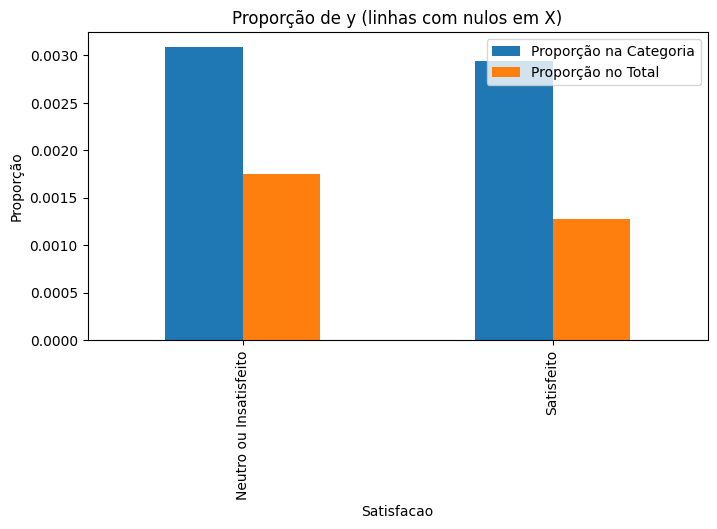


[DISTRIBUIÇÃO DE CLASSES]


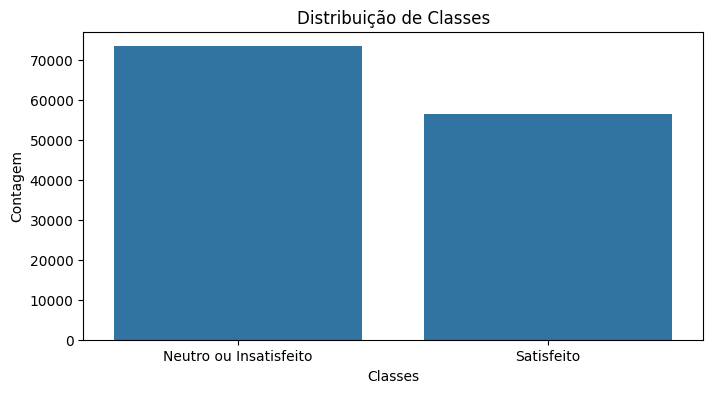

In [6]:
analisando_dados_do_dataset(df)

In [7]:
# Separar X e y
X = df.drop(columns=['Satisfacao'])
y = df['Satisfacao']

# Definir se deseja aplicar transformação logarítmica e escalonamento
willUseScaler = True
willUseLogTransform = True

# Separar colunas numéricas e categóricas
colunas_numericas = X.select_dtypes(include=[np.number]).columns
colunas_categoricas = X.select_dtypes(include=['object']).columns

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

In [9]:
# Verificar se há colunas categóricas
if colunas_categoricas.empty:
    print("Não há colunas categóricas para transformar.")
else:
    # Criar o encoder
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

    # Ajustar o encoder no conjunto de treino e transformar
    X_train_categorico_encoded = encoder.fit_transform(X_train[colunas_categoricas])
    X_test_categorico_encoded = encoder.transform(X_test[colunas_categoricas])

    # Converter os resultados do OneHotEncoder para DataFrames
    X_train_categorico_encoded_df = pd.DataFrame(
        X_train_categorico_encoded,
        columns=encoder.get_feature_names_out(colunas_categoricas),
        index=X_train.index
    )
    X_test_categorico_encoded_df = pd.DataFrame(
        X_test_categorico_encoded,
        columns=encoder.get_feature_names_out(colunas_categoricas),
        index=X_test.index
    )

    # Concatenar as colunas numéricas e categóricas transformadas
    X_train = pd.concat([X_train[colunas_numericas], X_train_categorico_encoded_df], axis=1)
    X_test = pd.concat([X_test[colunas_numericas], X_test_categorico_encoded_df], axis=1)

    print("Colunas categóricas codificadas no conjunto de treino:")
    display(X_train_categorico_encoded_df.head())
    print("Colunas categóricas codificadas no conjunto de teste:")
    display(X_test_categorico_encoded_df.head())
    
# Criar o LabelEncoder
le = LabelEncoder()

# Ajustar o encoder no conjunto de treino e transformar
y_train_encoded = pd.Series(le.fit_transform(y_train), name="target")

# Transformar o conjunto de teste com o mesmo encoder
y_test_encoded = pd.Series(le.transform(y_test), name="target")

# Verificar os resultados
print("y_train codificado:")
display(y_train_encoded.head())
print("y_test codificado:")
display(y_test_encoded.head())

Colunas categóricas codificadas no conjunto de treino:


,Genero_Mulher,Tipo_Cliente_Cliente_Nao_Fiel,Tipo_Viagem_Viagem_Pessoal,Classe_Economica_Plus,Classe_Executivo
28817,1.0,0.0,0.0,0.0,1.0
39717,0.0,0.0,0.0,0.0,1.0
120220,1.0,0.0,0.0,0.0,1.0
47602,0.0,0.0,0.0,0.0,1.0
57721,1.0,0.0,0.0,0.0,1.0


Colunas categóricas codificadas no conjunto de teste:


,Genero_Mulher,Tipo_Cliente_Cliente_Nao_Fiel,Tipo_Viagem_Viagem_Pessoal,Classe_Economica_Plus,Classe_Executivo
93370,0.0,0.0,1.0,0.0,0.0
5074,0.0,0.0,0.0,0.0,1.0
120460,0.0,0.0,1.0,0.0,0.0
53503,1.0,0.0,1.0,0.0,0.0
48551,1.0,0.0,1.0,0.0,0.0


y_train codificado:


0    1
1    1
2    0
3    1
4    1
Name: target, dtype: int64

y_test codificado:


0    1
1    0
2    0
3    1
4    0
Name: target, dtype: int64

In [10]:
# Verificar valores nulos antes e depois do SimpleImputer
print("Valores nulos antes do imputação:")
display(X_train[colunas_numericas].isnull().sum())
display(X_test[colunas_numericas].isnull().sum())

# Aplicar o SimpleImputer
impu = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train[colunas_numericas] = impu.fit_transform(X_train[colunas_numericas])
X_test[colunas_numericas] = impu.transform(X_test[colunas_numericas])

print("Valores nulos após a imputação:")
display(pd.DataFrame(X_train, columns=colunas_numericas).isnull().sum())
display(pd.DataFrame(X_test, columns=colunas_numericas).isnull().sum())

Valores nulos antes do imputação:


Idade                          0
Distancia_Voo                  0
Wifi_Bordo                     0
Horario_Conveniente            0
Facilidade_Reserva_Online      0
Localizacao_Portao             0
Comida_Bebida                  0
Embarque_Online                0
Conforto_Assento               0
Entretenimento_Bordo           0
Servico_Bordo                  0
Espaco_Pernas                  0
Manuseio_Bagagem               0
Servico_Checkin                0
Servico_Bordo_Geral            0
Limpeza                        0
Atraso_Partida_Min             0
Atraso_Chegada_Min           271
dtype: int64

Idade                          0
Distancia_Voo                  0
Wifi_Bordo                     0
Horario_Conveniente            0
Facilidade_Reserva_Online      0
Localizacao_Portao             0
Comida_Bebida                  0
Embarque_Online                0
Conforto_Assento               0
Entretenimento_Bordo           0
Servico_Bordo                  0
Espaco_Pernas                  0
Manuseio_Bagagem               0
Servico_Checkin                0
Servico_Bordo_Geral            0
Limpeza                        0
Atraso_Partida_Min             0
Atraso_Chegada_Min           122
dtype: int64

Valores nulos após a imputação:


Idade                        0
Distancia_Voo                0
Wifi_Bordo                   0
Horario_Conveniente          0
Facilidade_Reserva_Online    0
Localizacao_Portao           0
Comida_Bebida                0
Embarque_Online              0
Conforto_Assento             0
Entretenimento_Bordo         0
Servico_Bordo                0
Espaco_Pernas                0
Manuseio_Bagagem             0
Servico_Checkin              0
Servico_Bordo_Geral          0
Limpeza                      0
Atraso_Partida_Min           0
Atraso_Chegada_Min           0
dtype: int64

Idade                        0
Distancia_Voo                0
Wifi_Bordo                   0
Horario_Conveniente          0
Facilidade_Reserva_Online    0
Localizacao_Portao           0
Comida_Bebida                0
Embarque_Online              0
Conforto_Assento             0
Entretenimento_Bordo         0
Servico_Bordo                0
Espaco_Pernas                0
Manuseio_Bagagem             0
Servico_Checkin              0
Servico_Bordo_Geral          0
Limpeza                      0
Atraso_Partida_Min           0
Atraso_Chegada_Min           0
dtype: int64

In [11]:
# Verificar o resultado final de X
print("X final após transformações:")
display(X_train.head())

# Verificar o resultado final de y
print("y final após transformações:")
display(y_train[:5])

X final após transformações:


,Idade,Distancia_Voo,Wifi_Bordo,Horario_Conveniente,Facilidade_Reserva_Online,Localizacao_Portao,Comida_Bebida,Embarque_Online,Conforto_Assento,Entretenimento_Bordo,Servico_Bordo,Espaco_Pernas,Manuseio_Bagagem,Servico_Checkin,Servico_Bordo_Geral,Limpeza,Atraso_Partida_Min,Atraso_Chegada_Min,Genero_Mulher,Tipo_Cliente_Cliente_Nao_Fiel,Tipo_Viagem_Viagem_Pessoal,Classe_Economica_Plus,Classe_Executivo
28817,46.0,2447.0,4.0,4.0,2.0,4.0,2.0,1.0,3.0,5.0,5.0,5.0,5.0,1.0,5.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
39717,30.0,320.0,2.0,2.0,2.0,2.0,3.0,4.0,3.0,3.0,2.0,4.0,1.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
120220,53.0,2824.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0
47602,49.0,1428.0,4.0,4.0,4.0,4.0,5.0,3.0,1.0,5.0,5.0,5.0,5.0,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
57721,29.0,1754.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,2.0,3.0,3.0,5.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


y final após transformações:


28817                 Satisfeito
39717                 Satisfeito
120220    Neutro ou Insatisfeito
47602                 Satisfeito
57721                 Satisfeito
Name: Satisfacao, dtype: object

In [12]:
# Definir limiares para baixa correlação e baixa importância
limiar_correlacao = 0.0025

# Filtrar apenas colunas numéricas
X_numerico = X_train.select_dtypes(include=[np.number])

# Garantir que os valores sejam não negativos
if (X_numerico < 0).any().any():
    X_numerico = X_numerico - X_numerico

# Calcular a importância categórica
importancia_categorica = calcular_importancia_categorica(pd.DataFrame(X_numerico), y_train_encoded)

importancia_categorica = calcular_log_chi2(importancia_categorica)
media_chi2 = importancia_categorica['Chi2'].mean()
desvio_padrao_chi2 = importancia_categorica['Chi2'].std()

print(importancia_categorica)
print (f'Média Chi2: {media_chi2}')
print (f'Desvio Padrão Chi2: {desvio_padrao_chi2}')

# Definir colunas com baixa importância categórica
colunas_baixa_importancia = importancia_categorica[
    (
        ( 
            (importancia_categorica['Chi2'] > (media_chi2 + 1.0 * desvio_padrao_chi2)) 
            | (importancia_categorica['Chi2'] < (media_chi2 - 1.0 * desvio_padrao_chi2))
        ) |
        (importancia_categorica['p-value'] > 0.05))
]['Feature'].values

# Definir colunas com alta importância categórica
colunas_com_alta_importancia = importancia_categorica[
    ~(
        ( 
            (importancia_categorica['Chi2'] > (media_chi2 + 1.0 * desvio_padrao_chi2)) 
            | (importancia_categorica['Chi2'] < (media_chi2 - 1.0 * desvio_padrao_chi2))
        ) |
        (importancia_categorica['p-value'] > 0.05))
]['Feature'].values


                          Feature       Chi2        p-value
1                   Distancia_Voo  15.729451   0.000000e+00
17             Atraso_Chegada_Min  10.317883   0.000000e+00
16             Atraso_Partida_Min  10.054095   0.000000e+00
7                 Embarque_Online   9.459237   0.000000e+00
20     Tipo_Viagem_Viagem_Pessoal   9.445877   0.000000e+00
22               Classe_Executivo   9.389707   0.000000e+00
0                           Idade   9.177226   0.000000e+00
9            Entretenimento_Bordo   8.942891   0.000000e+00
8                Conforto_Assento   8.631605   0.000000e+00
11                  Espaco_Pernas   8.452387   0.000000e+00
2                      Wifi_Bordo   8.445461   0.000000e+00
10                  Servico_Bordo   8.426406   0.000000e+00
15                        Limpeza   8.417610   0.000000e+00
19  Tipo_Cliente_Cliente_Nao_Fiel   7.858272   0.000000e+00
13                Servico_Checkin   7.800549   0.000000e+00
6                   Comida_Bebida   7.69

Colunas com baixa importância categórica:
Colunas com baixa importância categórica:


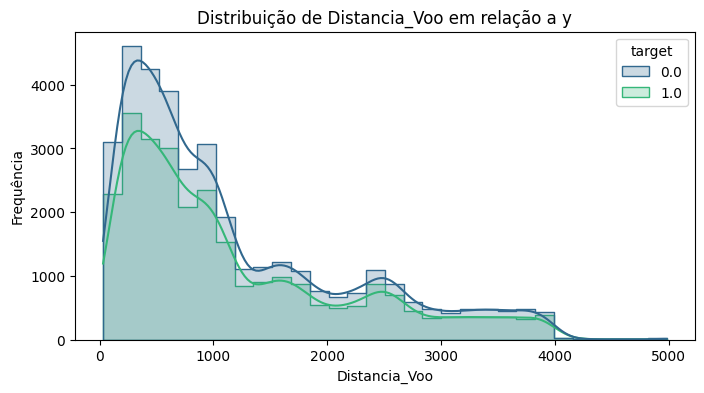

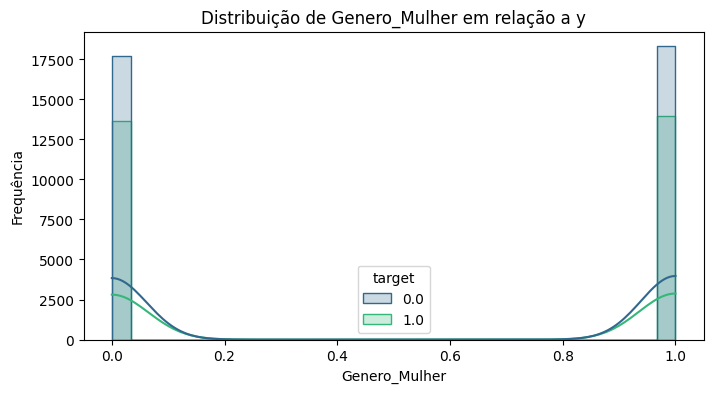

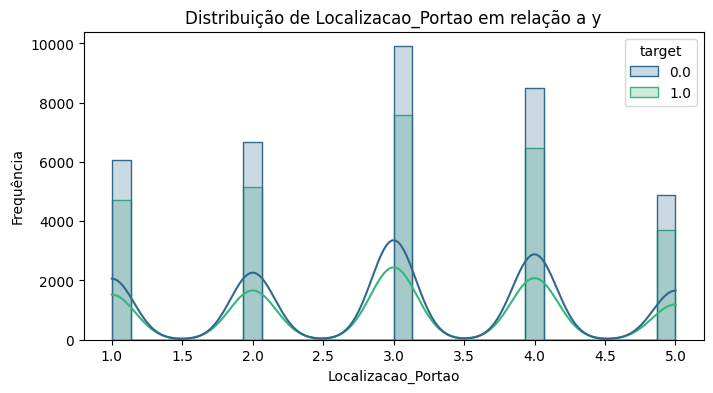

In [13]:
print("Colunas com baixa importância categórica:")
plotar_colunas(X_train, y_train_encoded, colunas_baixa_importancia, texto_de_print='Colunas com baixa importância categórica:')

Colunas com alta importância categórica:
Colunas com alta importância categórica:


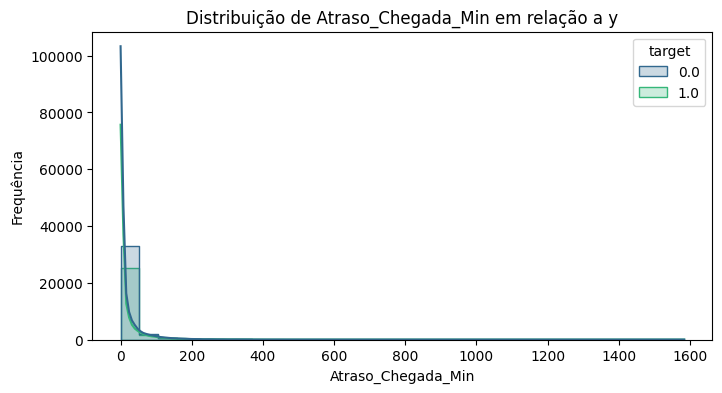

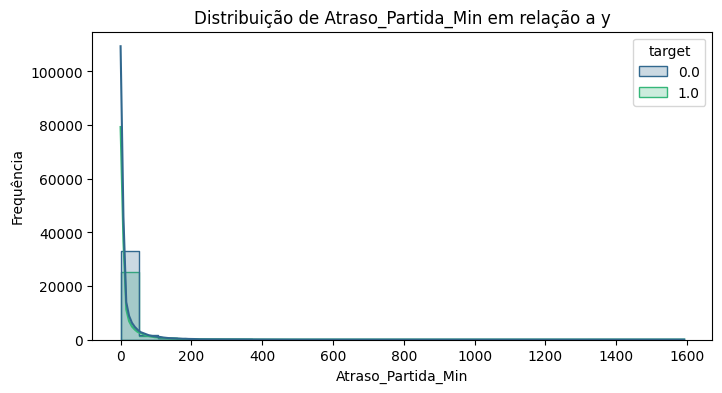

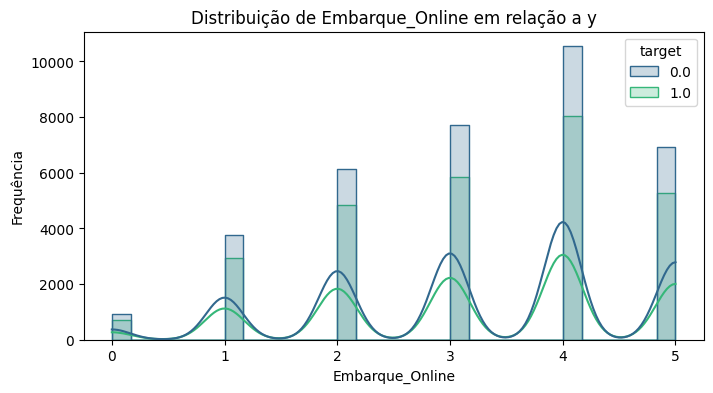

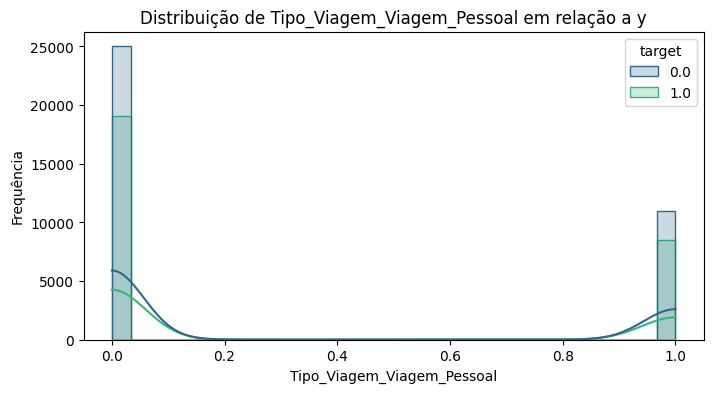

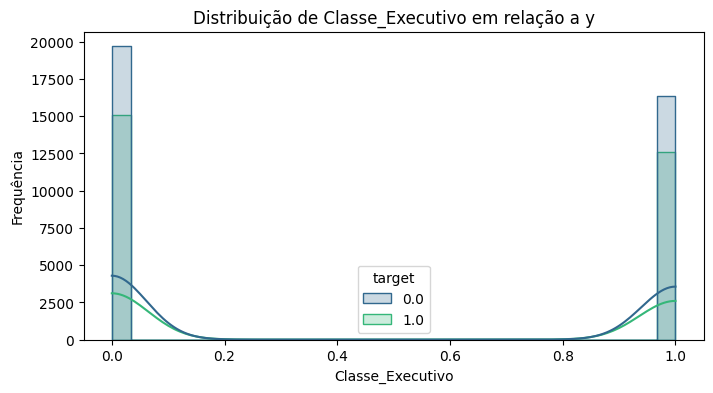

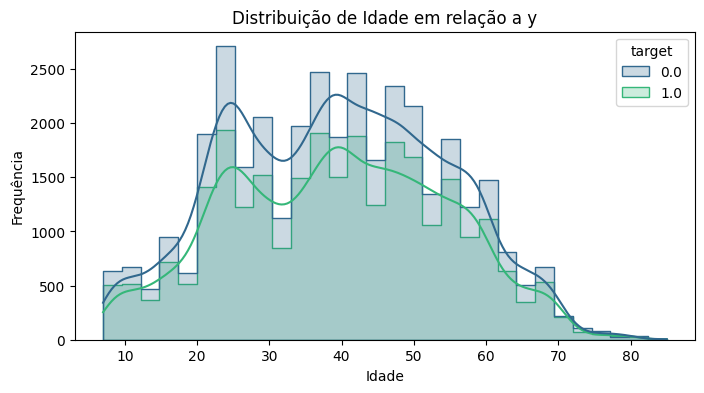

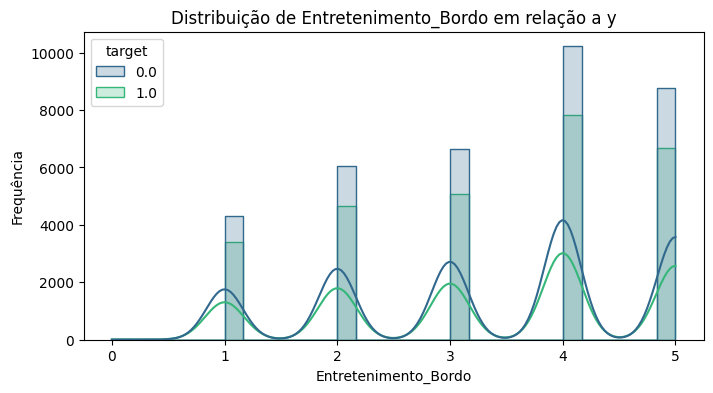

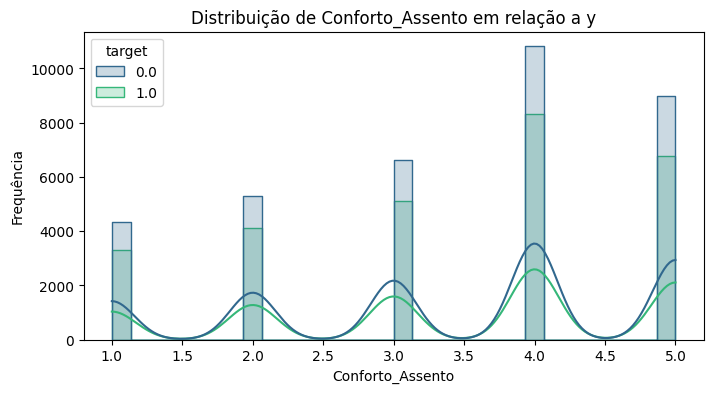

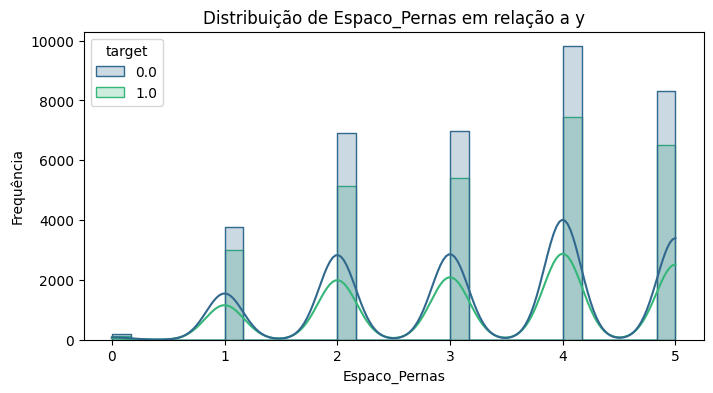

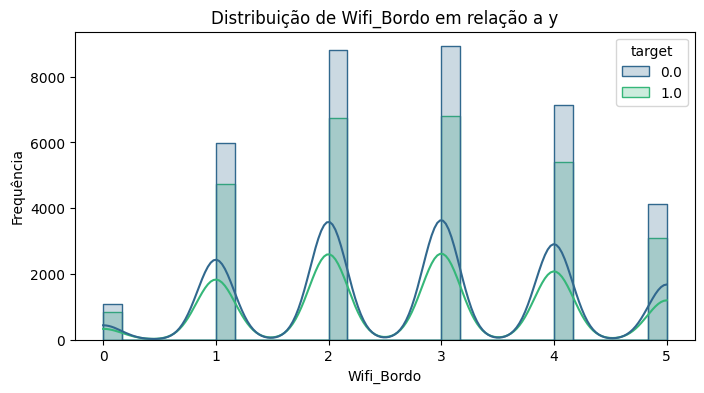

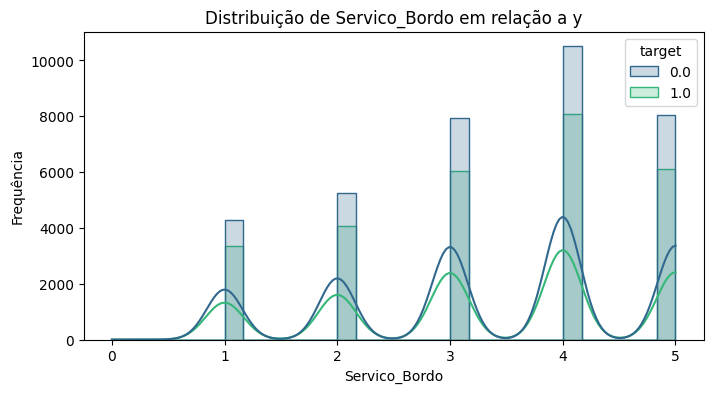

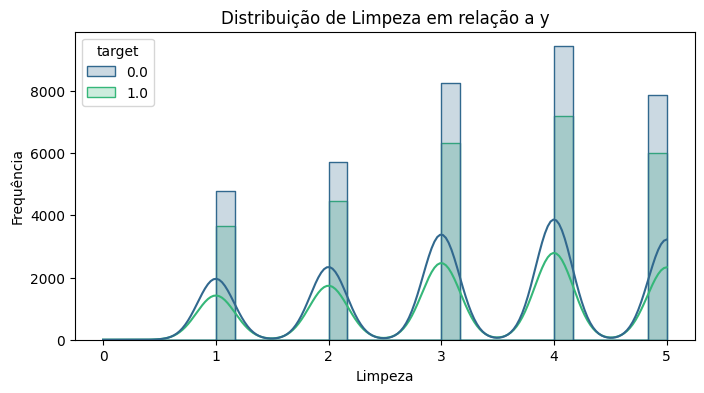

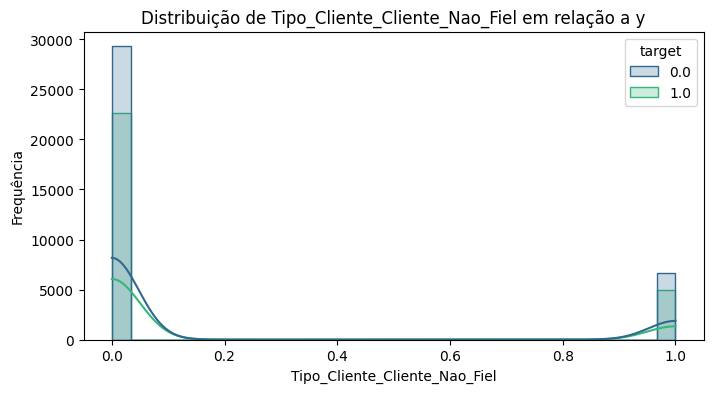

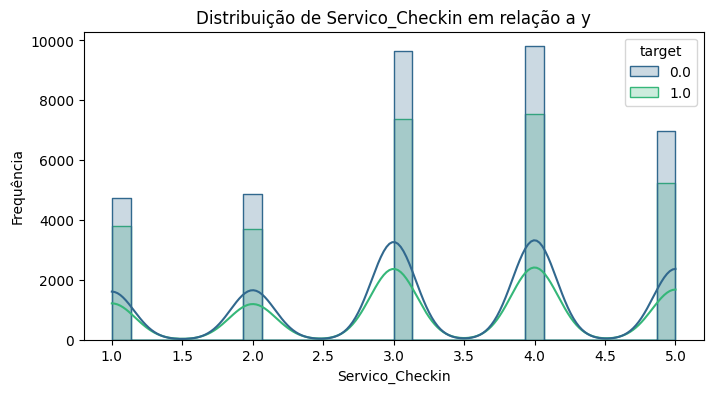

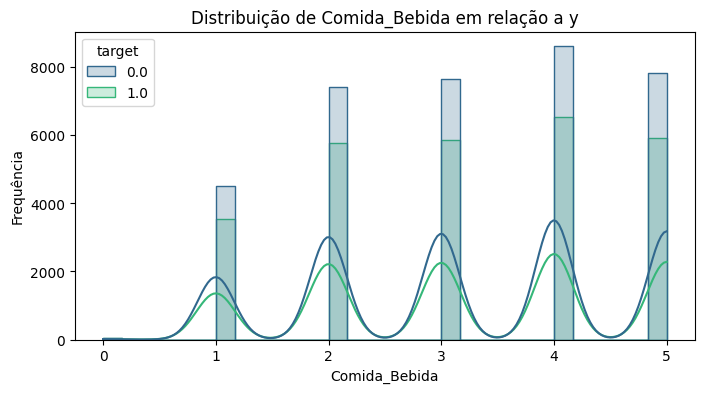

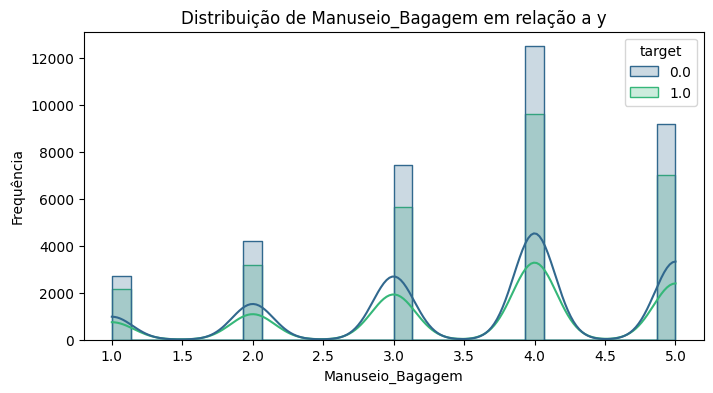

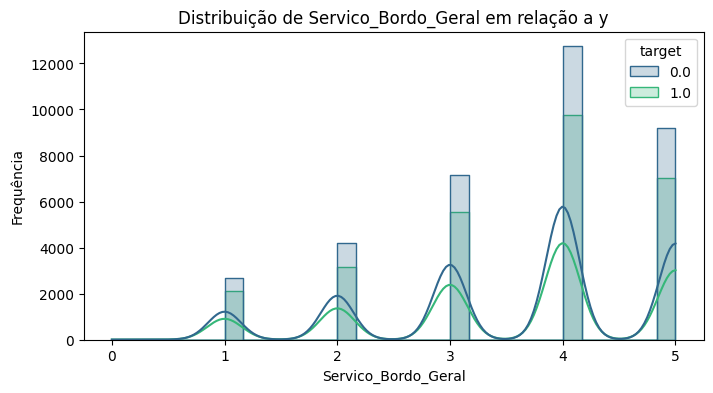

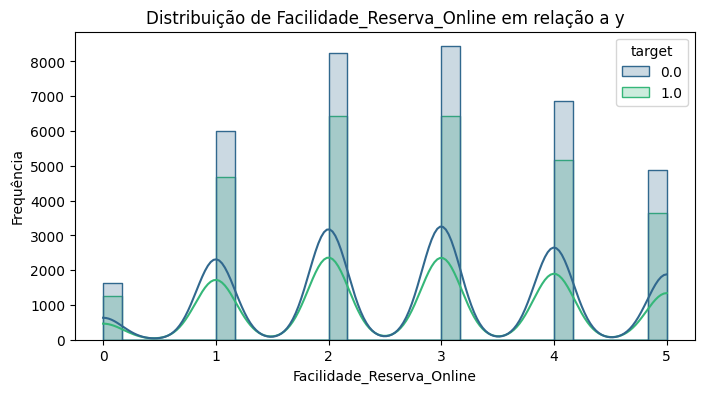

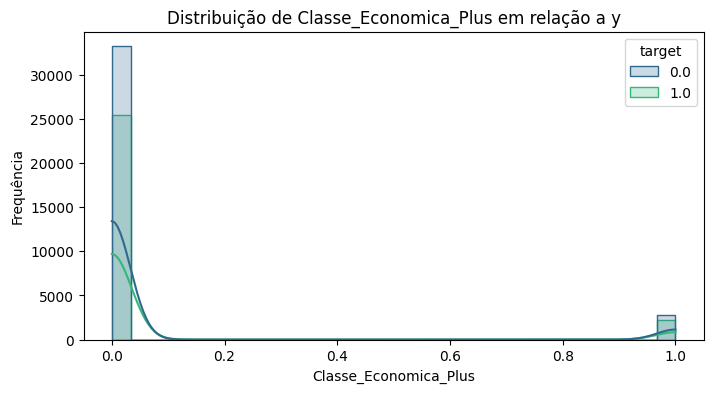

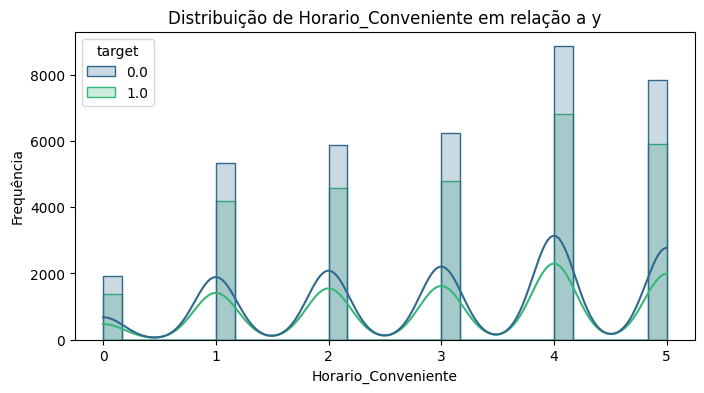

In [14]:
# Exibir colunas com alta importância categórica
print("Colunas com alta importância categórica:")
plotar_colunas(X_train, y_train_encoded, colunas_com_alta_importancia, texto_de_print='Colunas com alta importância categórica:')

In [15]:
limiar_colinearidade_y = 0.002
# Calcular correlação para colunas numéricas no conjunto de treino
correlacoes = calcular_correlacao(X_train[colunas_com_alta_importancia], y_train_encoded)

# Identificar colunas com Alta Correlação com o y
colunas_alta_correlacao = correlacoes[correlacoes.abs() > limiar_colinearidade_y].index  # Ajuste o limiar conforme necessário

# Identificar colunas com Baixa Correlação com o y
colunas_baixa_correlacao = correlacoes[correlacoes.abs() < limiar_colinearidade_y].index

Correlação com y:
Idade                            0.006530
Atraso_Partida_Min               0.003686
Espaco_Pernas                    0.003301
Tipo_Viagem_Viagem_Pessoal       0.003071
Atraso_Chegada_Min               0.002362
Classe_Executivo                 0.001832
Classe_Economica_Plus            0.001795
Servico_Bordo_Geral             -0.002046
Limpeza                         -0.002943
Conforto_Assento                -0.002997
Horario_Conveniente             -0.003059
Manuseio_Bagagem                -0.003097
Servico_Bordo                   -0.003534
Entretenimento_Bordo            -0.003996
Embarque_Online                 -0.004786
Comida_Bebida                   -0.005810
Servico_Checkin                 -0.007232
Facilidade_Reserva_Online       -0.007468
Tipo_Cliente_Cliente_Nao_Fiel   -0.007642
Wifi_Bordo                      -0.008103
dtype: float64


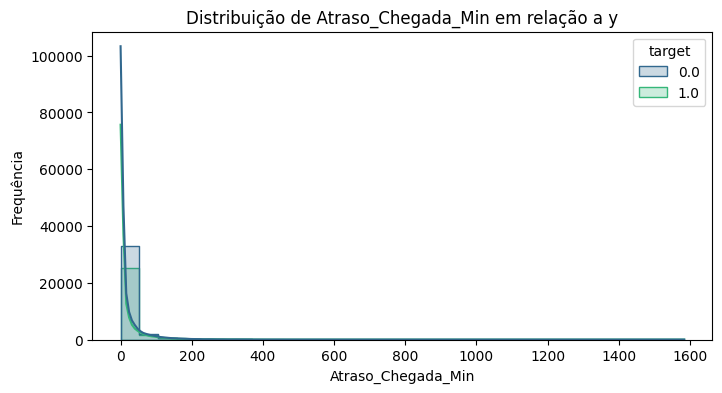

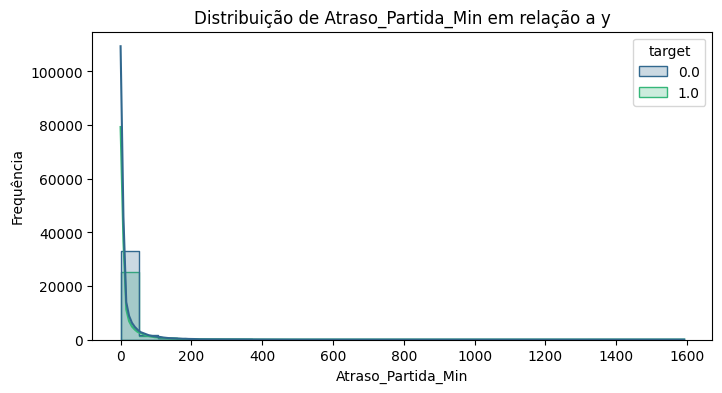

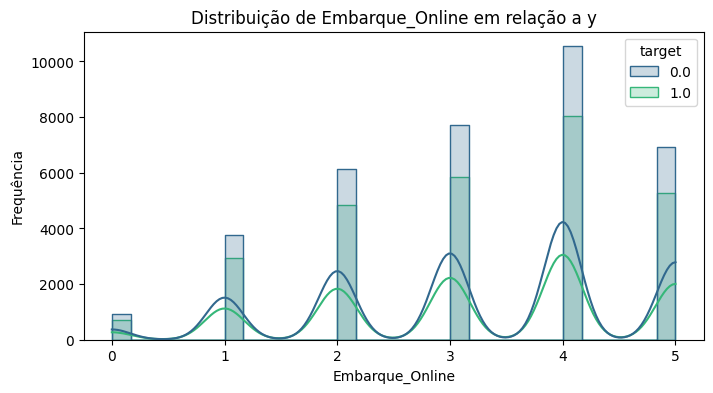

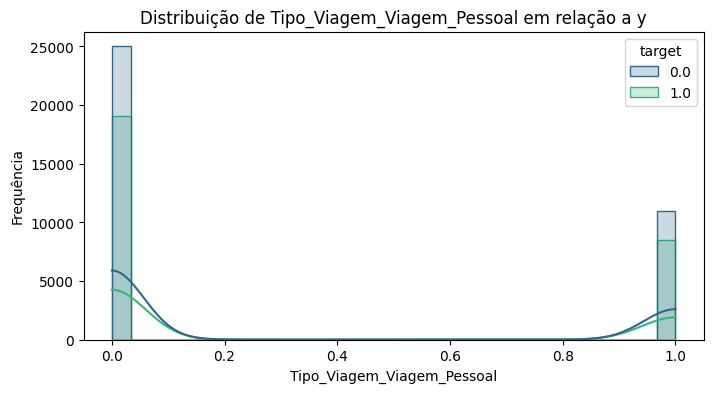

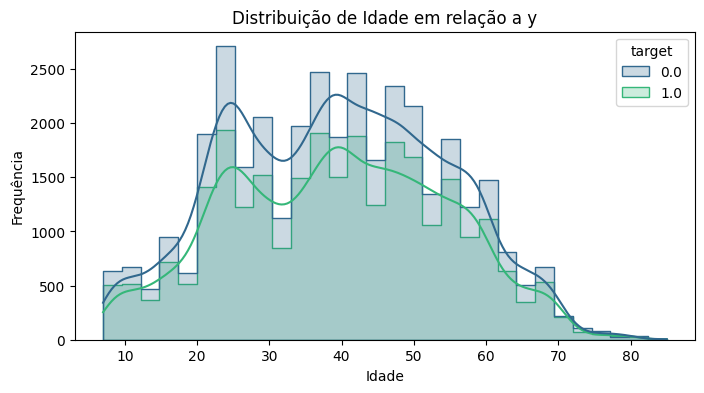

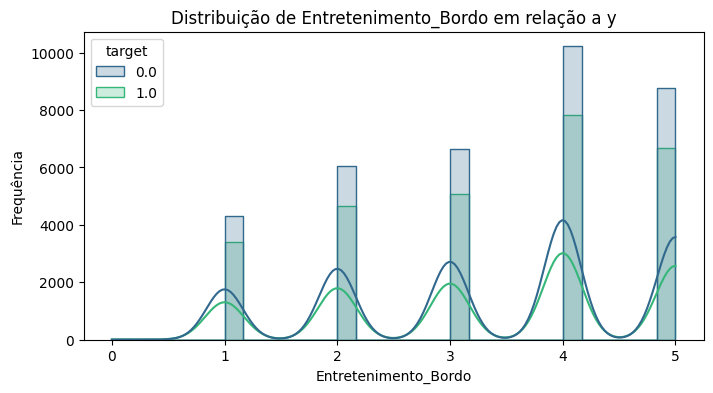

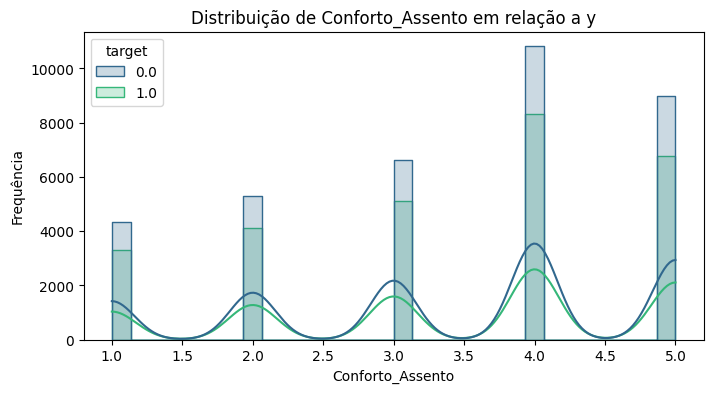

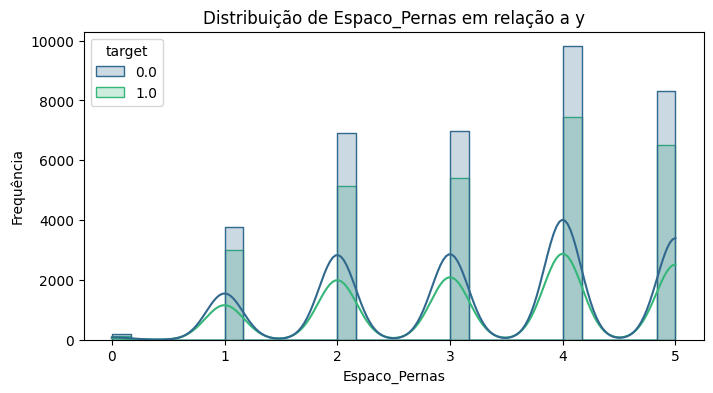

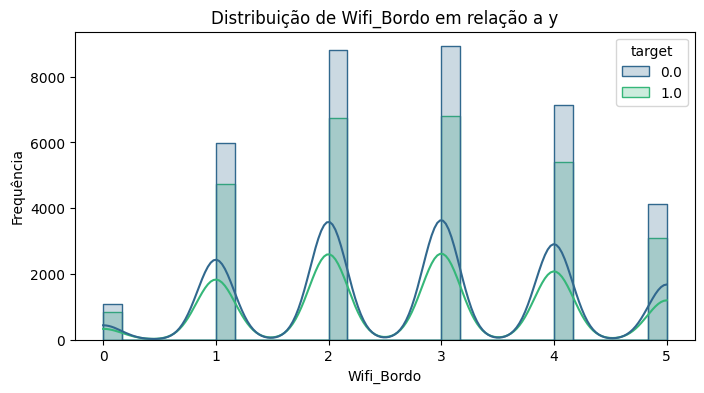

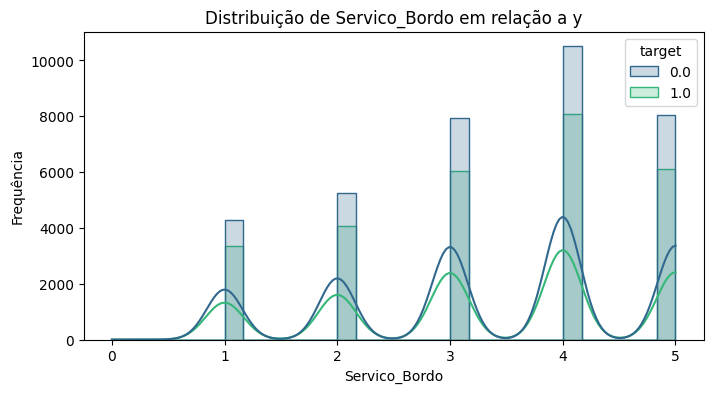

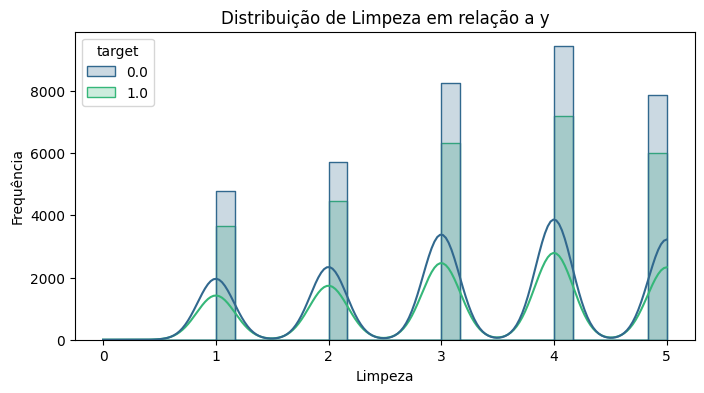

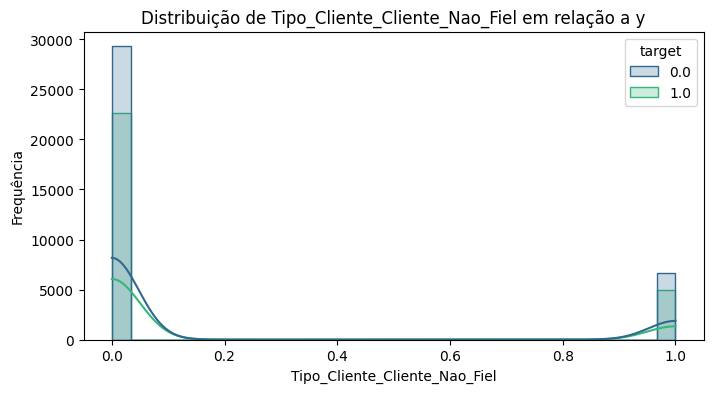

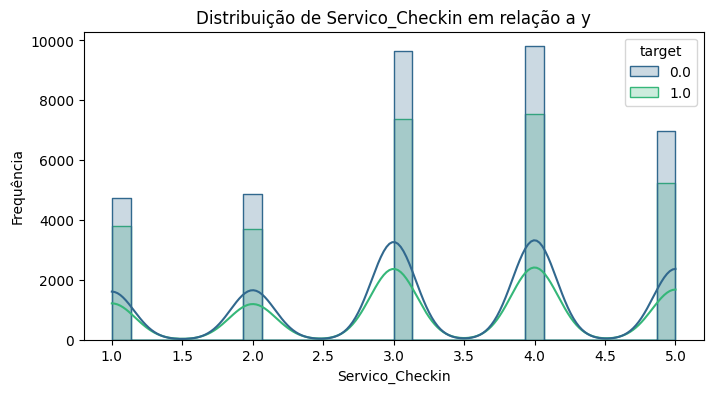

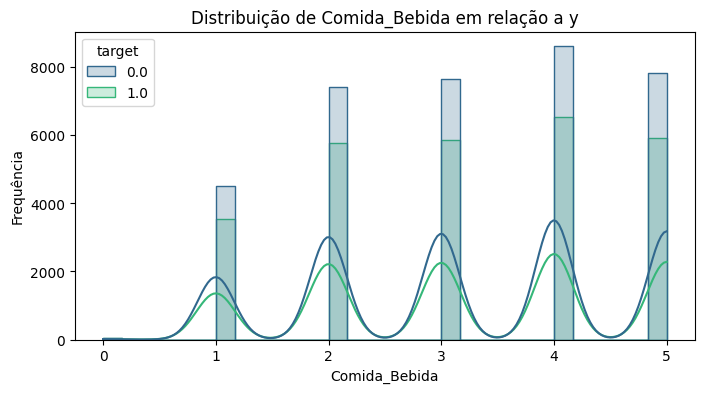

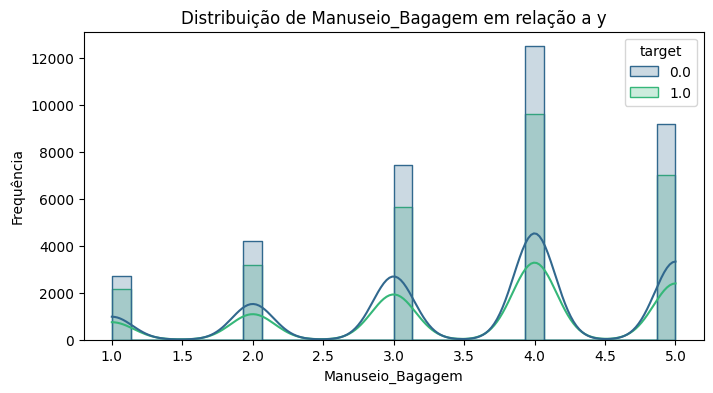

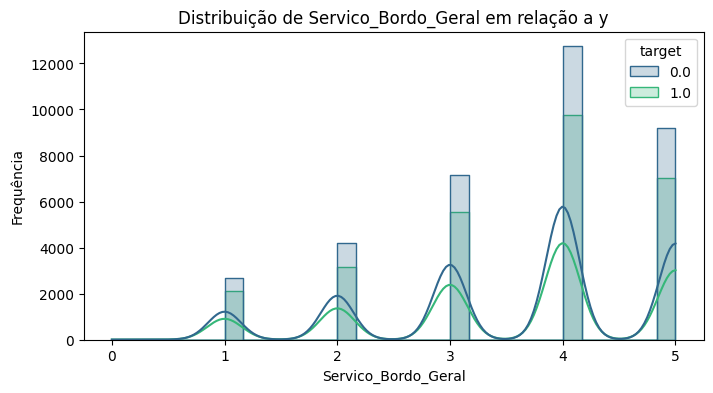

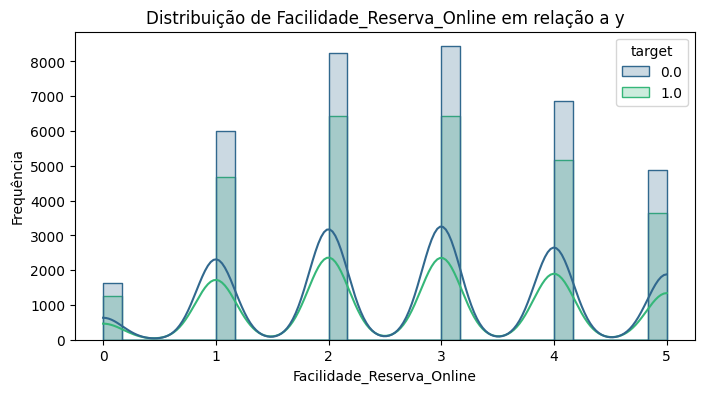

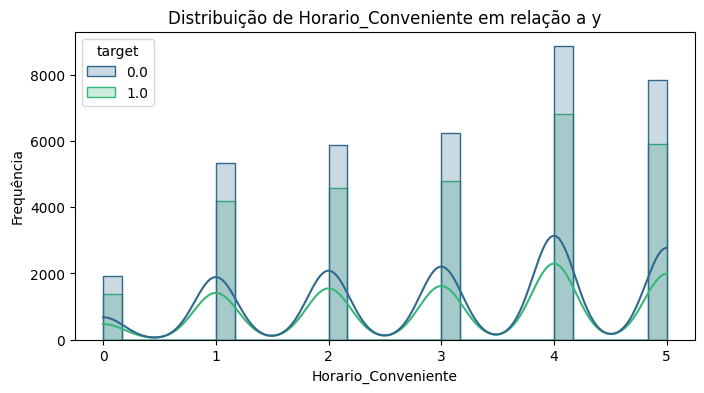

In [16]:
# Plotar colunas mais relevantes
plotar_colunas(X_train, y_train_encoded, colunas_alta_correlacao)

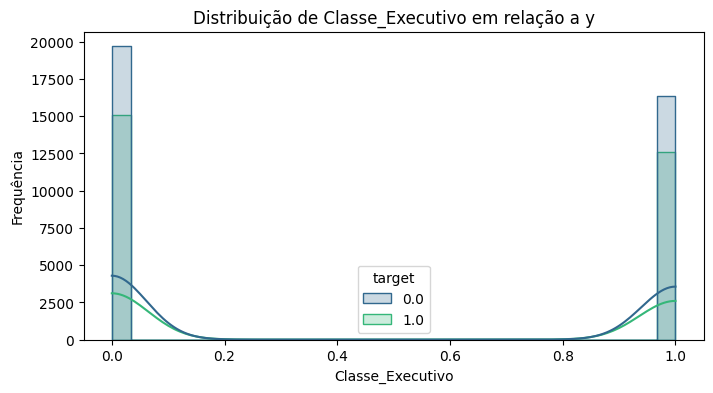

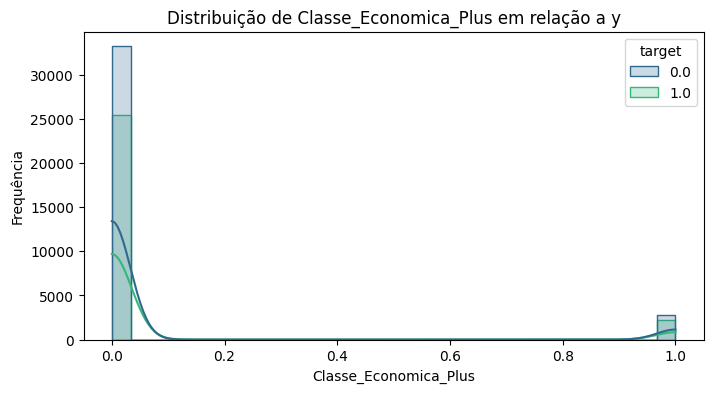

In [17]:
# Plotar colunas menos relevantes
plotar_colunas(X_train, y_train_encoded, colunas_baixa_correlacao)

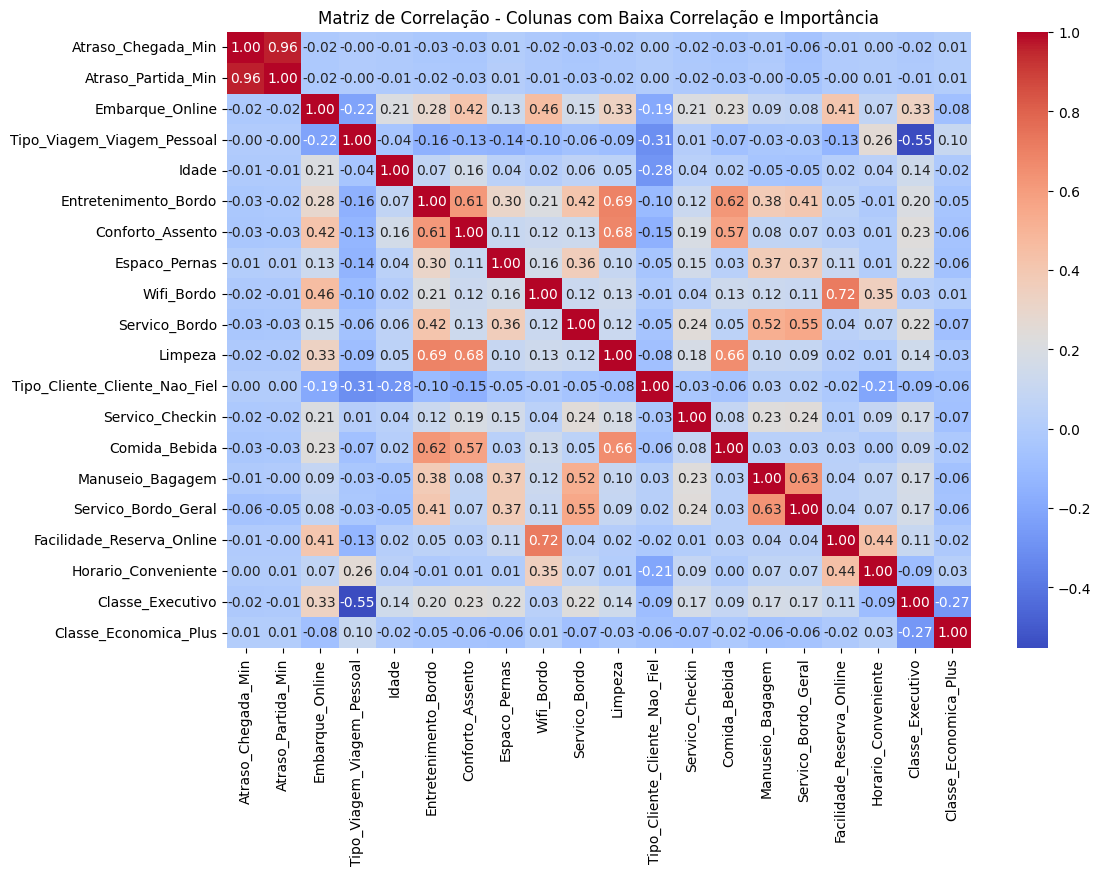

In [18]:
limiar_multicolinearidade = 0.8

# Binariar as colunas com baixa correlação e baixa importância categórica
colunas_para_analisar = list(colunas_alta_correlacao) + list(colunas_baixa_correlacao)
X_para_analisar = X_train[colunas_para_analisar]

# Criar a matriz de correlação
matriz_correlacao = X_para_analisar.corr()

# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size":10})
plt.title('Matriz de Correlação - Colunas com Baixa Correlação e Importância')
plt.show()

colunas_com_alta_correlacao_uma_a_outra = []

for i in range(len(matriz_correlacao.columns)):
    for j in range(i):
        if abs(matriz_correlacao.iloc[i, j]) > limiar_multicolinearidade:
            colunas_com_alta_correlacao_uma_a_outra.extend(
                (matriz_correlacao.columns[i], matriz_correlacao.columns[j])
            )
# remover duplicatas
colunas_com_alta_correlacao_uma_a_outra = list(set(colunas_com_alta_correlacao_uma_a_outra))

In [19]:
# Exibir colunas com alta correlação entre si
print("Colunas com alta correlação entre si:")
display(colunas_com_alta_correlacao_uma_a_outra)

Colunas com alta correlação entre si:


['Atraso_Partida_Min', 'Atraso_Chegada_Min']

In [20]:
# Combinar todas as features candidatas à remoção
features_para_remover = set(colunas_baixa_correlacao).union(set(colunas_baixa_importancia) | set(colunas_com_alta_correlacao_uma_a_outra))

display(f"Features com baixa correlação com y: {colunas_baixa_correlacao}")
display(f"Features multicolineares: {colunas_com_alta_correlacao_uma_a_outra}")
display(f"Features com baixa importância categórica: {colunas_baixa_importancia}")
display(f"Features candidatas à remoção: {features_para_remover}")

"Features com baixa correlação com y: Index(['Classe_Executivo', 'Classe_Economica_Plus'], dtype='object')"

"Features multicolineares: ['Atraso_Partida_Min', 'Atraso_Chegada_Min']"

"Features com baixa importância categórica: ['Distancia_Voo' 'Genero_Mulher' 'Localizacao_Portao']"

"Features candidatas à remoção: {'Classe_Executivo', 'Atraso_Chegada_Min', 'Localizacao_Portao', 'Classe_Economica_Plus', 'Genero_Mulher', 'Atraso_Partida_Min', 'Distancia_Voo'}"

In [21]:
# Dropando a feature Com alta Correlação Entre outra feature
features_escolhidas = ['Localizacao_Portao', 'Atraso_Chegada_Min', 'Atraso_Partida_Min', 'Classe_Economica_Plus', 'Genero_Mulher', 'Classe_Executivo', 'Distancia_Voo']

In [22]:
X_Train_sem_removidas = X_train.drop(columns=features_escolhidas)
X_Test_sem_removidas = X_test.drop(columns=features_escolhidas)

In [23]:
# Remover as features escolhidas dos índices de colunas numéricas e categóricas
colunas_numericas_sem_removidas = colunas_numericas.difference(features_escolhidas)
colunas_categoricas_sem = colunas_categoricas.difference(features_escolhidas)

# Verificar os resultados
print("Colunas numéricas com colunas removidas:")
display(colunas_numericas)
print("Colunas categóricas com colunas removidas:")
display(colunas_categoricas)

print("Colunas numericas sem colunas removidas:")
display(colunas_numericas_sem_removidas)
print("Colunas categóricas sem colunas removidas:")
display(colunas_categoricas_sem)

Colunas numéricas com colunas removidas:


Index(['Idade', 'Distancia_Voo', 'Wifi_Bordo', 'Horario_Conveniente',
       'Facilidade_Reserva_Online', 'Localizacao_Portao', 'Comida_Bebida',
       'Embarque_Online', 'Conforto_Assento', 'Entretenimento_Bordo',
       'Servico_Bordo', 'Espaco_Pernas', 'Manuseio_Bagagem', 'Servico_Checkin',
       'Servico_Bordo_Geral', 'Limpeza', 'Atraso_Partida_Min',
       'Atraso_Chegada_Min'],
      dtype='object')

Colunas categóricas com colunas removidas:


Index(['Genero', 'Tipo_Cliente', 'Tipo_Viagem', 'Classe'], dtype='object')

Colunas numericas sem colunas removidas:


Index(['Comida_Bebida', 'Conforto_Assento', 'Embarque_Online',
       'Entretenimento_Bordo', 'Espaco_Pernas', 'Facilidade_Reserva_Online',
       'Horario_Conveniente', 'Idade', 'Limpeza', 'Manuseio_Bagagem',
       'Servico_Bordo', 'Servico_Bordo_Geral', 'Servico_Checkin',
       'Wifi_Bordo'],
      dtype='object')

Colunas categóricas sem colunas removidas:


Index(['Classe', 'Genero', 'Tipo_Cliente', 'Tipo_Viagem'], dtype='object')

In [24]:
if willUseLogTransform:
    # Aplicar log-transform nas colunas numéricas
    X_train[colunas_numericas] = X_train[colunas_numericas].apply(lambda x: np.log((x + 1e-6)))
    X_test[colunas_numericas] = X_test[colunas_numericas].apply(lambda x: np.log((x + 1e-6)))
    X_Train_sem_removidas[colunas_numericas_sem_removidas] = X_Train_sem_removidas[colunas_numericas_sem_removidas].apply(lambda x: np.log(x + 1e-8))
    X_Test_sem_removidas[colunas_numericas_sem_removidas] = X_Test_sem_removidas[colunas_numericas_sem_removidas].apply(lambda x: np.log(x + 1e-8))

    # Verificar se a transformação log foi aplicada corretamente
    print("Colunas numéricas após log-transform:")
    display(X_train[colunas_numericas].head())
    display(X_test[colunas_numericas].head())
    print("Colunas numéricas sem colunas removidas após log-transform:")
    display(X_Train_sem_removidas[colunas_numericas_sem_removidas].head())
    display(X_Test_sem_removidas[colunas_numericas_sem_removidas].head())

Colunas numéricas após log-transform:


,Idade,Distancia_Voo,Wifi_Bordo,Horario_Conveniente,Facilidade_Reserva_Online,Localizacao_Portao,Comida_Bebida,Embarque_Online,Conforto_Assento,Entretenimento_Bordo,Servico_Bordo,Espaco_Pernas,Manuseio_Bagagem,Servico_Checkin,Servico_Bordo_Geral,Limpeza,Atraso_Partida_Min,Atraso_Chegada_Min
28817,3.828641,7.802618,1.386295e+00,1.386295,0.693148,1.386295,0.693148,9.999995e-07,1.098613e+00,1.609438e+00,1.609438e+00,1.609438,1.609438e+00,9.999995e-07,1.609438e+00,0.693148,-13.815511,-13.815511
39717,3.401197,5.768321,6.931477e-01,0.693148,0.693148,0.693148,1.098613,1.386295e+00,1.098613e+00,1.098613e+00,6.931477e-01,1.386295,9.999995e-07,9.999995e-07,1.098613e+00,1.098613,-13.815511,-13.815511
120220,3.970292,7.945910,9.999995e-07,1.098613,1.098613,1.098613,1.098613,1.098613e+00,1.098613e+00,9.999995e-07,9.999995e-07,0.693148,9.999995e-07,6.931477e-01,9.999995e-07,0.693148,-13.815511,1.098613
47602,3.891820,7.264030,1.386295e+00,1.386295,1.386295,1.386295,1.609438,1.098613e+00,9.999995e-07,1.609438e+00,1.609438e+00,1.609438,1.609438e+00,1.098613e+00,1.609438e+00,0.693148,-13.815511,-13.815511
57721,3.367296,7.469654,1.098613e+00,1.098613,1.098613,1.098613,1.386295,1.386295e+00,1.386295e+00,1.386295e+00,1.386295e+00,0.693148,1.098613e+00,1.098613e+00,1.609438e+00,1.386295,-13.815511,-13.815511


,Idade,Distancia_Voo,Wifi_Bordo,Horario_Conveniente,Facilidade_Reserva_Online,Localizacao_Portao,Comida_Bebida,Embarque_Online,Conforto_Assento,Entretenimento_Bordo,Servico_Bordo,Espaco_Pernas,Manuseio_Bagagem,Servico_Checkin,Servico_Bordo_Geral,Limpeza,Atraso_Partida_Min,Atraso_Chegada_Min
93370,4.143135,6.931472,1.386295e+00,1.386295,1.386295e+00,1.386295e+00,1.098613,1.386295e+00,1.098613e+00,1.098613,1.386295,0.693148,1.609438e+00,1.098613e+00,1.386295,1.098613e+00,-13.815511,-13.815511
5074,3.761200,5.407172,9.999995e-07,1.098613,1.386295e+00,1.098613e+00,0.693148,6.931477e-01,1.098613e+00,0.693148,0.693148,0.693148,9.999995e-07,1.098613e+00,0.693148,9.999995e-07,4.219508,4.820282
120460,4.025352,6.107023,9.999995e-07,1.609438,9.999995e-07,9.999995e-07,1.386295,9.999995e-07,1.386295e+00,1.386295,1.609438,1.098613,1.609438e+00,1.609438e+00,1.609438,1.386295e+00,-13.815511,-13.815511
53503,2.833213,7.791110,1.609438e+00,0.693148,1.609438e+00,1.098613e+00,1.609438,9.999995e-07,9.999995e-07,1.386295,1.609438,1.098613,1.386295e+00,9.999995e-07,1.098613,9.999995e-07,-13.815511,1.098613
48551,3.737670,6.739337,1.386295e+00,1.386295,1.386295e+00,1.098613e+00,1.098613,1.386295e+00,1.386295e+00,1.386295,1.386295,1.386295,1.386295e+00,1.609438e+00,1.386295,1.609438e+00,-13.815511,-13.815511


Colunas numéricas sem colunas removidas após log-transform:


,Comida_Bebida,Conforto_Assento,Embarque_Online,Entretenimento_Bordo,Espaco_Pernas,Facilidade_Reserva_Online,Horario_Conveniente,Idade,Limpeza,Manuseio_Bagagem,Servico_Bordo,Servico_Bordo_Geral,Servico_Checkin,Wifi_Bordo
28817,0.693147,1.098612e+00,1.000000e-08,1.609438e+00,1.609438,0.693147,1.386294,3.828641,0.693147,1.609438e+00,1.609438e+00,1.609438e+00,1.000000e-08,1.386294e+00
39717,1.098612,1.098612e+00,1.386294e+00,1.098612e+00,1.386294,0.693147,0.693147,3.401197,1.098612,1.000000e-08,6.931472e-01,1.098612e+00,1.000000e-08,6.931472e-01
120220,1.098612,1.098612e+00,1.098612e+00,1.000000e-08,0.693147,1.098612,1.098612,3.970292,0.693147,1.000000e-08,1.000000e-08,1.000000e-08,6.931472e-01,1.000000e-08
47602,1.609438,1.000000e-08,1.098612e+00,1.609438e+00,1.609438,1.386294,1.386294,3.891820,0.693147,1.609438e+00,1.609438e+00,1.609438e+00,1.098612e+00,1.386294e+00
57721,1.386294,1.386294e+00,1.386294e+00,1.386294e+00,0.693147,1.098612,1.098612,3.367296,1.386294,1.098612e+00,1.386294e+00,1.609438e+00,1.098612e+00,1.098612e+00


,Comida_Bebida,Conforto_Assento,Embarque_Online,Entretenimento_Bordo,Espaco_Pernas,Facilidade_Reserva_Online,Horario_Conveniente,Idade,Limpeza,Manuseio_Bagagem,Servico_Bordo,Servico_Bordo_Geral,Servico_Checkin,Wifi_Bordo
93370,1.098612,1.098612e+00,1.386294e+00,1.098612,0.693147,1.386294e+00,1.386294,4.143135,1.098612e+00,1.609438e+00,1.386294,1.386294,1.098612e+00,1.386294e+00
5074,0.693147,1.098612e+00,6.931472e-01,0.693147,0.693147,1.386294e+00,1.098612,3.761200,1.000000e-08,1.000000e-08,0.693147,0.693147,1.098612e+00,1.000000e-08
120460,1.386294,1.386294e+00,1.000000e-08,1.386294,1.098612,1.000000e-08,1.609438,4.025352,1.386294e+00,1.609438e+00,1.609438,1.609438,1.609438e+00,1.000000e-08
53503,1.609438,1.000000e-08,1.000000e-08,1.386294,1.098612,1.609438e+00,0.693147,2.833213,1.000000e-08,1.386294e+00,1.609438,1.098612,1.000000e-08,1.609438e+00
48551,1.098612,1.386294e+00,1.386294e+00,1.386294,1.386294,1.386294e+00,1.386294,3.737670,1.609438e+00,1.386294e+00,1.386294,1.386294,1.609438e+00,1.386294e+00


In [25]:
# Transformar colunas numéricas com escalonamento
if willUseScaler:
    print("Colunas numéricas após log-transform:")
    display(X_train[colunas_numericas].head())
    scaler = StandardScaler()
    
    # Escalonar colunas numéricas
    X_train[colunas_numericas] = scaler.fit_transform(X_train[colunas_numericas])
    X_test[colunas_numericas] = scaler.transform(X_test[colunas_numericas])
    X_Train_sem_removidas[colunas_numericas_sem_removidas] = scaler.fit_transform(X_Train_sem_removidas[colunas_numericas_sem_removidas])
    X_Test_sem_removidas[colunas_numericas_sem_removidas] = scaler.transform(X_Test_sem_removidas[colunas_numericas_sem_removidas])
    
    # Verificar se o escalonamento foi aplicado corretamente
    print("Colunas numéricas escalonadas:")
    display(X_train[colunas_numericas].head())
    display(X_test[colunas_numericas].head())
    print("Colunas numéricas sem colunas removidas escalonadas:")
    display(X_Train_sem_removidas[colunas_numericas_sem_removidas].head())
    display(X_Test_sem_removidas[colunas_numericas_sem_removidas].head())

Colunas numéricas após log-transform:


,Idade,Distancia_Voo,Wifi_Bordo,Horario_Conveniente,Facilidade_Reserva_Online,Localizacao_Portao,Comida_Bebida,Embarque_Online,Conforto_Assento,Entretenimento_Bordo,Servico_Bordo,Espaco_Pernas,Manuseio_Bagagem,Servico_Checkin,Servico_Bordo_Geral,Limpeza,Atraso_Partida_Min,Atraso_Chegada_Min
28817,3.828641,7.802618,1.386295e+00,1.386295,0.693148,1.386295,0.693148,9.999995e-07,1.098613e+00,1.609438e+00,1.609438e+00,1.609438,1.609438e+00,9.999995e-07,1.609438e+00,0.693148,-13.815511,-13.815511
39717,3.401197,5.768321,6.931477e-01,0.693148,0.693148,0.693148,1.098613,1.386295e+00,1.098613e+00,1.098613e+00,6.931477e-01,1.386295,9.999995e-07,9.999995e-07,1.098613e+00,1.098613,-13.815511,-13.815511
120220,3.970292,7.945910,9.999995e-07,1.098613,1.098613,1.098613,1.098613,1.098613e+00,1.098613e+00,9.999995e-07,9.999995e-07,0.693148,9.999995e-07,6.931477e-01,9.999995e-07,0.693148,-13.815511,1.098613
47602,3.891820,7.264030,1.386295e+00,1.386295,1.386295,1.386295,1.609438,1.098613e+00,9.999995e-07,1.609438e+00,1.609438e+00,1.609438,1.609438e+00,1.098613e+00,1.609438e+00,0.693148,-13.815511,-13.815511
57721,3.367296,7.469654,1.098613e+00,1.098613,1.098613,1.098613,1.386295,1.386295e+00,1.386295e+00,1.386295e+00,1.386295e+00,0.693148,1.098613e+00,1.098613e+00,1.609438e+00,1.386295,-13.815511,-13.815511


Colunas numéricas escalonadas:


,Idade,Distancia_Voo,Wifi_Bordo,Horario_Conveniente,Facilidade_Reserva_Online,Localizacao_Portao,Comida_Bebida,Embarque_Online,Conforto_Assento,Entretenimento_Bordo,Servico_Bordo,Espaco_Pernas,Manuseio_Bagagem,Servico_Checkin,Servico_Bordo_Geral,Limpeza,Atraso_Partida_Min,Atraso_Chegada_Min
28817,0.532361,1.197492,0.355941,0.333412,0.132376,0.790579,-0.499716,-0.320973,-0.064795,0.944525,0.980125,0.506873,0.914876,-2.208612,0.893904,-0.728115,-0.873089,-0.880958
39717,-0.387967,-1.016772,0.086597,0.126269,0.132376,-0.535618,0.084909,0.273630,-0.064795,-0.004424,-0.844913,0.306613,-2.804672,-2.208612,-0.269542,0.035953,-0.873089,-0.880958
120220,0.837348,1.353460,-0.182748,0.247440,0.264526,0.240157,0.084909,0.150239,-0.064795,-2.045290,-2.225500,-0.315452,-2.804672,-0.808635,-2.771720,-0.728115,-0.873089,0.921616
47602,0.668391,0.611257,0.355941,0.333412,0.358287,0.790579,0.821450,0.150239,-2.240322,0.944525,0.980125,0.506873,0.914876,0.010299,0.893904,-0.728115,-0.873089,-0.880958
57721,-0.460961,0.835072,0.244153,0.247440,0.264526,0.240157,0.499708,0.273630,0.504888,0.529996,0.535675,-0.315452,-0.265686,0.010299,0.893904,0.578068,-0.873089,-0.880958


,Idade,Distancia_Voo,Wifi_Bordo,Horario_Conveniente,Facilidade_Reserva_Online,Localizacao_Portao,Comida_Bebida,Embarque_Online,Conforto_Assento,Entretenimento_Bordo,Servico_Bordo,Espaco_Pernas,Manuseio_Bagagem,Servico_Checkin,Servico_Bordo_Geral,Limpeza,Atraso_Partida_Min,Atraso_Chegada_Min
93370,1.209496,0.249278,0.355941,0.333412,0.358287,0.790579,0.084909,0.273630,-0.064795,-0.004424,0.535675,-0.315452,0.914876,0.010299,0.385677,0.035953,-0.873089,-0.880958
5074,0.387154,-1.409871,-0.182748,0.247440,0.358287,0.240157,-0.499716,-0.023671,-0.064795,-0.757647,-0.844913,-0.315452,-2.804672,0.010299,-1.193022,-2.034297,1.315886,1.371431
120460,0.955898,-0.648107,-0.182748,0.400097,-0.093536,-1.861815,0.499708,-0.320973,0.504888,0.529996,0.980125,0.048432,0.914876,1.042034,0.893904,0.578068,-0.873089,-0.880958
53503,-1.610892,1.184965,0.442651,0.126269,0.431015,0.240157,0.821450,-0.320973,-2.240322,0.529996,0.980125,0.048432,0.399172,-2.208612,-0.269542,-2.034297,-0.873089,0.921616
48551,0.336490,0.040146,0.355941,0.333412,0.358287,0.240157,0.084909,0.273630,0.504888,0.529996,0.535675,0.306613,0.399172,1.042034,0.385677,0.998565,-0.873089,-0.880958


Colunas numéricas sem colunas removidas escalonadas:


,Comida_Bebida,Conforto_Assento,Embarque_Online,Entretenimento_Bordo,Espaco_Pernas,Facilidade_Reserva_Online,Horario_Conveniente,Idade,Limpeza,Manuseio_Bagagem,Servico_Bordo,Servico_Bordo_Geral,Servico_Checkin,Wifi_Bordo
28817,-0.427095,-0.064795,-0.210942,0.913244,0.418597,0.152085,0.310956,0.532361,-0.707817,0.914876,0.970396,0.882276,-2.208613,0.314991
39717,0.079380,-0.064795,0.247435,-0.003182,0.259107,0.152085,0.151983,-0.387967,0.035828,-2.804673,-0.835969,-0.265591,-2.208613,0.108086
120220,0.079380,-0.064795,0.152313,-1.974103,-0.236315,0.253396,0.244977,0.837348,-0.707817,-2.804673,-2.202432,-2.734263,-0.808635,-0.098818
47602,0.717464,-2.240322,0.152313,0.913244,0.418597,0.325277,0.310956,0.668391,-0.707817,0.914876,0.970396,0.882276,0.010299,0.314991
57721,0.438730,0.504888,0.247435,0.512922,-0.236315,0.253396,0.244977,-0.460961,0.563453,-0.265685,0.530494,0.882276,0.010299,0.229118


,Comida_Bebida,Conforto_Assento,Embarque_Online,Entretenimento_Bordo,Espaco_Pernas,Facilidade_Reserva_Online,Horario_Conveniente,Idade,Limpeza,Manuseio_Bagagem,Servico_Bordo,Servico_Bordo_Geral,Servico_Checkin,Wifi_Bordo
93370,0.079380,-0.064795,0.247435,-0.003182,-0.236315,0.325277,0.310956,1.209496,0.035828,0.914876,0.530494,0.380854,0.010299,0.314991
5074,-0.427095,-0.064795,0.018247,-0.730590,-0.236315,0.325277,0.244977,0.387154,-1.979087,-2.804673,-0.835969,-1.176705,0.010299,-0.098818
120460,0.438730,0.504888,-0.210942,0.512922,0.053488,-0.021108,0.362134,0.955898,0.563453,0.914876,0.970396,0.882276,1.042034,-0.098818
53503,0.717464,-2.240322,-0.210942,0.512922,0.053488,0.381033,0.151983,-1.610892,-1.979087,0.399172,0.970396,-0.265591,-2.208613,0.381600
48551,0.079380,0.504888,0.247435,0.512922,0.259107,0.325277,0.310956,0.336490,0.972711,0.399172,0.530494,0.380854,1.042034,0.314991


### Agora que toda a parte de tratamento e exploração foi feita, vamos treinar o modelo

#### Treinamento do modelo

In [26]:
display(X_train.head())

,Idade,Distancia_Voo,Wifi_Bordo,Horario_Conveniente,Facilidade_Reserva_Online,Localizacao_Portao,Comida_Bebida,Embarque_Online,Conforto_Assento,Entretenimento_Bordo,Servico_Bordo,Espaco_Pernas,Manuseio_Bagagem,Servico_Checkin,Servico_Bordo_Geral,Limpeza,Atraso_Partida_Min,Atraso_Chegada_Min,Genero_Mulher,Tipo_Cliente_Cliente_Nao_Fiel,Tipo_Viagem_Viagem_Pessoal,Classe_Economica_Plus,Classe_Executivo
28817,0.532361,1.197492,0.355941,0.333412,0.132376,0.790579,-0.499716,-0.320973,-0.064795,0.944525,0.980125,0.506873,0.914876,-2.208612,0.893904,-0.728115,-0.873089,-0.880958,1.0,0.0,0.0,0.0,1.0
39717,-0.387967,-1.016772,0.086597,0.126269,0.132376,-0.535618,0.084909,0.273630,-0.064795,-0.004424,-0.844913,0.306613,-2.804672,-2.208612,-0.269542,0.035953,-0.873089,-0.880958,0.0,0.0,0.0,0.0,1.0
120220,0.837348,1.353460,-0.182748,0.247440,0.264526,0.240157,0.084909,0.150239,-0.064795,-2.045290,-2.225500,-0.315452,-2.804672,-0.808635,-2.771720,-0.728115,-0.873089,0.921616,1.0,0.0,0.0,0.0,1.0
47602,0.668391,0.611257,0.355941,0.333412,0.358287,0.790579,0.821450,0.150239,-2.240322,0.944525,0.980125,0.506873,0.914876,0.010299,0.893904,-0.728115,-0.873089,-0.880958,0.0,0.0,0.0,0.0,1.0
57721,-0.460961,0.835072,0.244153,0.247440,0.264526,0.240157,0.499708,0.273630,0.504888,0.529996,0.535675,-0.315452,-0.265686,0.010299,0.893904,0.578068,-0.873089,-0.880958,1.0,0.0,0.0,0.0,1.0


In [27]:



bscv = BayesSearchCV(
    estimator= LogisticRegression(),
    search_spaces={
        'C': Real(1e-3, 1.0, prior='log-uniform'),
        'solver': Categorical(['liblinear', 'lbfgs']),
        'max_iter': Integer(100, 500),
    },
    n_iter=1,
    cv=3,
    scoring='f1',
    random_state=42
)
bscv.fit(X_train, y_train_encoded)
display('Treinamento do modelo com BayesSearchCV com as features não removidas')
print("Melhores parâmetros encontrados:")
display(bscv.best_params_)
print("Melhor pontuação:")
display(bscv.best_score_)
print("Melhor estimador:")
display(bscv.best_estimator_)
print("Melhor pontuação de validação cruzada:")
display(bscv.cv_results_['mean_test_score'][bscv.best_index_])
print("Melhores parâmetros encontrados:")
display(bscv.best_params_)

bscv_sem_removidas = BayesSearchCV(
    estimator= LogisticRegression(),
    search_spaces={
        'C': Real(1e-3, 1.0, prior='log-uniform'),
        'solver': Categorical(['liblinear', 'lbfgs']),
        'max_iter': Integer(100, 500),
    },
    n_iter=1,
    cv=3,
    scoring='f1',
    random_state=42
)
print("Treinamento do modelo com BayesSearchCV com as features removidas")
bscv_sem_removidas.fit(X_Train_sem_removidas, y_train_encoded)
print("Melhores parâmetros encontrados:")
display(bscv_sem_removidas.best_params_)
print("Melhor pontuação:")
display(bscv_sem_removidas.best_score_)
print("Melhor estimador:")
display(bscv_sem_removidas.best_estimator_)
print("Melhor pontuação de validação cruzada:")
display(bscv_sem_removidas.cv_results_['mean_test_score'][bscv_sem_removidas.best_index_])
print("Melhores parâmetros encontrados:")
display(bscv_sem_removidas.best_params_)

'Treinamento do modelo com BayesSearchCV com as features não removidas'

Melhores parâmetros encontrados:


OrderedDict([('C', 0.016994636371262764),
             ('max_iter', 391),
             ('solver', 'lbfgs')])

Melhor pontuação:


np.float64(0.8288180053321512)

Melhor estimador:


LogisticRegression(C=0.016994636371262764, max_iter=391)

Melhor pontuação de validação cruzada:


np.float64(0.8288180053321512)

Melhores parâmetros encontrados:


OrderedDict([('C', 0.016994636371262764),
             ('max_iter', 391),
             ('solver', 'lbfgs')])

Treinamento do modelo com BayesSearchCV com as features removidas
Melhores parâmetros encontrados:


OrderedDict([('C', 0.016994636371262764),
             ('max_iter', 391),
             ('solver', 'lbfgs')])

Melhor pontuação:


np.float64(0.8300201790110845)

Melhor estimador:


LogisticRegression(C=0.016994636371262764, max_iter=391)

Melhor pontuação de validação cruzada:


np.float64(0.8300201790110845)

Melhores parâmetros encontrados:


OrderedDict([('C', 0.016994636371262764),
             ('max_iter', 391),
             ('solver', 'lbfgs')])

## Modelo Automatizado por Pipelines

In [28]:
# Listas de colunas
make_one_hot_features_pt = [
    'Genero',
    'Tipo_Cliente',
    'Tipo_Viagem',
    'Classe'
]

make_drop_features_pt = [
    'Localizacao_Portao', 
    'Atraso_Chegada_Min', 
    'Atraso_Partida_Min', 
    'Classe_Economica_Plus', 
    'Genero_Mulher', 
    'Classe_Executivo', 
    'Distancia_Voo'
]

make_standard_features_pt = [
    'Idade',
    'Wifi_Bordo',
    'Horario_Conveniente',
    'Facilidade_Reserva_Online',
    'Comida_Bebida',
    'Embarque_Online',
    'Conforto_Assento',
    'Entretenimento_Bordo',
    'Servico_Bordo',
    'Espaco_Pernas',
    'Manuseio_Bagagem',
    'Servico_Checkin',
    'Servico_Bordo_Geral',
    'Limpeza',
]

make_log_features_pt = ['Idade']

make_impute_features = [
    'Idade', 'Wifi_Bordo', 'Horario_Conveniente', 
    'Facilidade_Reserva_Online', 'Comida_Bebida', 'Embarque_Online', 
    'Conforto_Assento', 'Entretenimento_Bordo', 'Servico_Bordo', 
    'Espaco_Pernas', 'Manuseio_Bagagem', 'Servico_Checkin', 
    'Servico_Bordo_Geral', 'Limpeza'
]

colunas_finais = [
    "Tipo_Cliente_Cliente_Nao_Fiel", 
    "Tipo_Viagem_Viagem_Pessoal", 
    "Idade", 
    "Wifi_Bordo", 
    "Horario_Conveniente", 
    "Facilidade_Reserva_Online", 
    "Comida_Bebida", 
    "Embarque_Online", 
    "Conforto_Assento", 
    "Entretenimento_Bordo", 
    "Servico_Bordo", 
    "Espaco_Pernas", 
    "Manuseio_Bagagem", 
    "Servico_Checkin", 
    "Servico_Bordo_Geral", 
    "Limpeza"
]

colunas_nao_transformadas = list(set(colunas_finais) - set(make_log_features_pt) - set(make_standard_features_pt))

def drop_columns(df, columns_to_drop):
    return df.drop(columns=columns_to_drop, axis=1)

def log_transform(x):
    print("Transformando com log")
    print(x.head())
    print(x.shape)
    x_result = np.log(x + 1e-8)
    print(x_result.head())
    print(x_result.shape)
    return x_result

def fazer_one_hot_encoding(X):
    """
    Aplica OneHot Encoding nas colunas categóricas especificadas e retorna o DataFrame atualizado.

    Parâmetros:
    - X (pd.DataFrame): DataFrame original.

    Retorna:
    - pd.DataFrame: DataFrame com as colunas categóricas transformadas.
    """
    # Aplicar OneHotEncoder
    categorical_ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    X_encoded = categorical_ohe.fit_transform(X[make_one_hot_features_pt])

    # Converter o resultado do OneHotEncoder para DataFrame
    X_encoded_df = pd.DataFrame(
        X_encoded,
        columns=categorical_ohe.get_feature_names_out(make_one_hot_features_pt),
        index=X.index
    )

    return pd.concat(
        [X_encoded_df, X.drop(columns=make_one_hot_features_pt)], axis=1
    )


# 1. OneHot Encoding
def imputar_e_atualizar_dataframe(X):
    """
    Imputa valores nas colunas especificadas e retorna o DataFrame atualizado.

    Parâmetros:
    - X (pd.DataFrame): DataFrame original.
    - colunas_imputadas (list): Lista de nomes das colunas que serão imputadas.

    Retorna:
    - pd.DataFrame: DataFrame com as colunas imputadas atualizadas.
    """
    # Copiar o DataFrame original para evitar modificações
    X = X.copy()

    # Aplicar o SimpleImputer nas colunas especificadas
    imputer = SimpleImputer(strategy='mean')
    valores_imputados = imputer.fit_transform(X[colunas_finais])

    # Criar um DataFrame com os valores imputados
    df_imputado = pd.DataFrame(valores_imputados, columns=colunas_finais, index=X.index)

    # Substituir as colunas imputadas no DataFrame original
    X.update(df_imputado)

    return X

def remover_colunas(X):
    return drop_columns(X, make_drop_features_pt)

def to_dataframe(X, columns):
    return pd.DataFrame(X, columns=columns)

def remover_duplicatas(X):
    return pd.DataFrame(X).loc[:, ~pd.DataFrame(X).columns.duplicated()]

def teste(X):
    return X

# Completa
preprocessor_completa = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p, validate=False), make_log_features_pt),
        ('scaler', StandardScaler(), make_standard_features_pt),
    ], remainder='passthrough'
)

preprocessor_sem_log = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), make_standard_features_pt)
    ], remainder='passthrough'
)

preprocessor_sem_scaler = ColumnTransformer(
    transformers=[
        
        ('log', FunctionTransformer(np.log1p, validate=False), make_log_features_pt)
    ], remainder='passthrough'
)

# Criar as pipelines usando os ColumnTransformers
pipeline_completa = Pipeline(steps=[
    ('preprocessor', preprocessor_completa),
    ('to_dataframe', FunctionTransformer(
        to_dataframe, kw_args={'columns': colunas_finais}, validate=False
    ))
])

pipeline_sem_log = Pipeline(steps=[
    ('preprocessor', preprocessor_sem_log),
    ('to_dataframe', FunctionTransformer(
        to_dataframe, kw_args={'columns': colunas_finais}, validate=False
    ))
])

pipeline_sem_scaler = Pipeline(steps=[
    ('preprocessor', preprocessor_sem_scaler),
    ('to_dataframe', FunctionTransformer(
        to_dataframe, kw_args={'columns': colunas_finais}, validate=False
    ))
])

pipeline_puro = Pipeline(steps=[
    ('to_dataframe', FunctionTransformer(
        to_dataframe, kw_args={'columns': colunas_finais}, validate=False
    ))
])

balancing_pipeline = ImbPipeline([
    ('smote_tomek', SMOTETomek(smote=SMOTE(sampling_strategy='minority')))
])

search_spaces_logistic = {
    'classifier__C': Real(1e-3, 7.0, prior='log-uniform'),   #mudando pra 0.7 assim até 70% , modelo mais simples, que dá menos overfitting, se for maior pode ser mais complexo e ter overfitting
    'classifier__max_iter': Integer(100, 1000),              # de 100,1000 para 100, 1500numero de interções, se for baixo o modelo pode não encontar o melhor, se for alto pode se ajustar demais
}

search_spaces_random_forest = {
    'classifier__n_estimators': Integer(50, 100),           #voltei, ficou muito lento - mudando de 50,100 para  100 e 300 , mais melhora o overfithing e a ruidos especificos, se for muito alto pode ser custoso e não muda muito
    'classifier__max_depth': Integer(2, 10),                 #mudei para de 2,10 para 2,12, melhora arvore mais profundas tem risco de overfitting mas melhora a performance
    'classifier__bootstrap': Categorical([True, False]), 
    'classifier__min_samples_leaf': Integer(1, 3),          # mudei de 1 que é o padrão, para 1 e 5, com mais folhas temos menos chance de overfing mas temos menos padroes que ela pegou
}

search_spaces_decision_tree = {
    'classifier__criterion': Categorical(['gini', 'entropy']),
    'classifier__splitter': Categorical(['best', 'random']),#random é pra modelos datasets grandes
    'classifier__min_samples_leaf': Integer(1, 3),  # numero de folhas, se for muito baixo pode ter overfitting
    'classifier__max_depth': Integer(2, 10),   #2 pra ser mais rapido e vai até 10 que é mais preciso
}

search_spaces_knn = {
    'classifier__n_neighbors': Integer(2, 10), # numero de vizinhos, se for 1 causa overfitting. abaixo de 3 geralmente não é bom
    'classifier__weights': Categorical(['uniform', 'distance']),     # 'distance' pesa mais os vizinhos próximos,dá menos impacto de outliers, pode ajudar contra overfitting.
    'classifier__algorithm': Categorical(['auto', 'kd_tree']) #auto, o skitlearn escolhes ele mesmo, ball_tree e kd_tree são similares, mas o ball_tree é pra < 30 features ja o kd_tree é pra media e alta dimensionalidade, pesa mais
}

search_spaces_sgd = {
    'classifier__loss': Categorical(['hinge', 'log_loss', 'squared_hinge', 'modified_huber']),
    'classifier__penalty': Categorical(['l2', 'l1', 'elasticnet']),
    'classifier__alpha': Real(1e-5, 1e-1, prior='log-uniform'), #    # Controla a força da regularização, força ele a generalizar. Valores maiores => mais regularização => menos overfitting
    'classifier__early_stopping': Categorical([True, False]), #Para o treinamento automaticamente quando não há melhora na validação. Evita overfitting em ciclos longos de treino.
    'classifier__max_iter': Integer(100, 1000)
}

search_spaces_ridge_classifier = {
    'classifier__alpha': Real(1e-5, 1e-1, prior='log-uniform'), # evita underfitting com 1e-1
    'classifier__solver': Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
    'classifier__max_iter': Integer(100, 1000),
}

In [29]:
# Carregar dados para pipeline e vizualiuzação do durante o notebook
df = pl.read_csv('fly_satisfaction.csv')
# Converter para PyArrow Table
arrow_table = df.to_arrow()
# Converter para Pandas DataFrame
df = pd.DataFrame(arrow_table.to_pydict())
df = update_column_names_and_values(df)
# Verificar o DataFrame
display(df.head())

,Genero,Tipo_Cliente,Idade,Tipo_Viagem,Classe,Distancia_Voo,Wifi_Bordo,Horario_Conveniente,Facilidade_Reserva_Online,Localizacao_Portao,Comida_Bebida,Embarque_Online,Conforto_Assento,Entretenimento_Bordo,Servico_Bordo,Espaco_Pernas,Manuseio_Bagagem,Servico_Checkin,Servico_Bordo_Geral,Limpeza,Atraso_Partida_Min,Atraso_Chegada_Min,Satisfacao
0,Homem,Cliente_Nao_Fiel,48,Viagem_Negocios,Executivo,821,3,3,3,3,5,3,5,5,3,2,5,4,5,5,2,5.0,Neutro ou Insatisfeito
1,Mulher,Cliente_Fiel,35,Viagem_Negocios,Executivo,821,2,2,2,2,3,5,4,5,5,5,5,3,5,5,26,39.0,Satisfeito
2,Homem,Cliente_Fiel,41,Viagem_Negocios,Executivo,853,4,4,4,4,5,5,5,3,3,3,3,4,3,5,0,0.0,Satisfeito
3,Homem,Cliente_Fiel,50,Viagem_Negocios,Executivo,1905,2,2,2,2,4,4,5,5,5,5,5,3,5,4,0,0.0,Satisfeito
4,Mulher,Cliente_Fiel,49,Viagem_Negocios,Executivo,3470,3,3,3,3,4,5,4,3,3,4,3,3,3,5,0,1.0,Satisfeito


In [30]:

def reconstruir_dataframe(X, X_transformed, colunas_transformadas, colunas_originais):
    # Identificar colunas não transformadas
    colunas_nao_transformadas = list(set(colunas_originais) - set(colunas_transformadas))
    
    # Criar DataFrame com as colunas transformadas
    df_transformado = pd.DataFrame(X_transformed, columns=colunas_transformadas, index=X.index)
    
    # Adicionar as colunas não transformadas
    df_nao_transformadas = X[colunas_nao_transformadas]
    
    # Concatenar os DataFrames
    return pd.concat([df_transformado, df_nao_transformadas], axis=1)

def preprocess_and_balance(X_train, X_test, y_train, pipeline, balance_pipeline=None):
    """
    Aplica o pré-processamento e o balanceamento nos dados de treino e teste.
    """
    print(f"Tipo do pipeline: {type(pipeline)}")
    print(f"Shape de X_train antes do pipeline: {X_train.shape}")
    if pipeline is pipeline_completa:
        X_train_processed = preprocessor_completa.fit_transform(X_train)
        reconstruir_dataframe(X_train, X_train_processed, colunas_finais, X_train.columns)
    else:
        X_train_processed = pipeline.fit_transform(X_train)
    print(f"Shape de X_train após o pipeline: {X_train_processed.shape}")
    X_test_processed = pipeline.transform(X_test)
    print(f"Shape de X_test após o pipeline: {X_test_processed.shape}")
    if balance_pipeline:
        X_train_processed, y_train = balance_pipeline.fit_resample(X_train_processed, y_train)
    return X_train_processed, X_test_processed, y_train

def avaliar_modelos_pipeline(X_train, X_test, y_train, y_test, search_spaces, modelo: sklearn.base.BaseEstimator = LogisticRegression, 
                              pipeline=None, balance_pipeline=None, scaled=False, log_transform=False, cv=3, n_iter=10, n_jobs=-1):
    """
    Avalia modelos usando pipelines de pré-processamento e balanceamento.
    """
    # Determinar o pipeline correto
    if pipeline is None:
        raise ValueError("Um pipeline de pré-processamento deve ser fornecido.")
    
    # Aplicar pré-processamento e balanceamento
    X_train_processed, X_test_processed, y_train_processed = preprocess_and_balance(
        X_train, X_test, y_train, pipeline, balance_pipeline
    )
    
    # Configurar o modelo no pipeline
    pipeline_a_ser_usada = Pipeline(steps=[('preproc', pipeline), ('classifier', modelo)])
    
    bayes_search = BayesSearchCV(
        estimator=pipeline_a_ser_usada,
        search_spaces=search_spaces,
        scoring='f1',
        n_iter=n_iter,  # Ajuste conforme o tempo disponível
        cv=cv,
        n_jobs=-n_jobs,
        verbose=2,
        random_state=42
    )
    
    display(f"Treinando com a Pipeline: {pipeline_a_ser_usada}")
    
    # Treina o BayesSearchCV
    bayes_search.fit(X_train_processed, y_train_processed)
    display(f"Melhor pontuação: {bayes_search.best_score_}")
    display(f"Melhores hiperparâmetros: {bayes_search.best_params_}")

    # Pega o melhor pipeline encontrado
    melhor_pipeline = bayes_search.best_estimator_

    # Faz predições com o melhor pipeline
    y_pred_train = cross_val_predict(melhor_pipeline, X_train_processed, y_train_processed, cv=3, n_jobs=-1)
    y_pred_test = melhor_pipeline.predict(X_test_processed)

    return {
        'Modelo': type(melhor_pipeline.named_steps['classifier']).__name__ + (' (Escalado)' if scaled else '') + (' (Log Transformado)' if log_transform else ''),
        'Melhor Modelo': bayes_search.best_estimator_,
        'Accuracy Train': accuracy_score(y_train_processed, y_pred_train),
        'Accuracy Test': accuracy_score(y_test, y_pred_test),
        'Precision Train': precision_score(y_train_processed, y_pred_train),
        'Precision Test': precision_score(y_test, y_pred_test),
        'Recall Train': recall_score(y_train_processed, y_pred_train),
        'Recall Test': recall_score(y_test, y_pred_test),
        'F1 Score Train': f1_score(y_train_processed, y_pred_train),
        'F1 Score Test': f1_score(y_test, y_pred_test),
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'Melhores Hiperparâmetros': bayes_search.best_params_
    }

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Separando os dados em treino e teste
print("DataFrame shape:")
display(df.shape)
print("First few rows of the DataFrame:\n",)
display( df.head())

X = df.drop('Satisfacao', axis=1)
y = df['Satisfacao']
y = y.map({'Neutro ou Insatisfeito': 0, 'Satisfeito': 1})
# result = acorr_ljungbox(y_pipeline.map({'Neutro ou Insatisfeito':0, 'Satisfeito': 1}), lags=5)
# print(result)  # Se p-valor > 0.05, não há autocorrelação


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)



DataFrame shape:


(129880, 23)

First few rows of the DataFrame:



,Genero,Tipo_Cliente,Idade,Tipo_Viagem,Classe,Distancia_Voo,Wifi_Bordo,Horario_Conveniente,Facilidade_Reserva_Online,Localizacao_Portao,Comida_Bebida,Embarque_Online,Conforto_Assento,Entretenimento_Bordo,Servico_Bordo,Espaco_Pernas,Manuseio_Bagagem,Servico_Checkin,Servico_Bordo_Geral,Limpeza,Atraso_Partida_Min,Atraso_Chegada_Min,Satisfacao
0,Homem,Cliente_Nao_Fiel,48,Viagem_Negocios,Executivo,821,3,3,3,3,5,3,5,5,3,2,5,4,5,5,2,5.0,Neutro ou Insatisfeito
1,Mulher,Cliente_Fiel,35,Viagem_Negocios,Executivo,821,2,2,2,2,3,5,4,5,5,5,5,3,5,5,26,39.0,Satisfeito
2,Homem,Cliente_Fiel,41,Viagem_Negocios,Executivo,853,4,4,4,4,5,5,5,3,3,3,3,4,3,5,0,0.0,Satisfeito
3,Homem,Cliente_Fiel,50,Viagem_Negocios,Executivo,1905,2,2,2,2,4,4,5,5,5,5,5,3,5,4,0,0.0,Satisfeito
4,Mulher,Cliente_Fiel,49,Viagem_Negocios,Executivo,3470,3,3,3,3,4,5,4,3,3,4,3,3,3,5,0,1.0,Satisfeito


In [32]:
# testando pipeline indivuidualmente

X = df.drop('Satisfacao', axis=1)
y = df['Satisfacao']
y = y.map({'Neutro ou Insatisfeito': 0, 'Satisfeito': 1})
# result = acorr_ljungbox(y_pipeline.map({'Neutro ou Insatisfeito':0, 'Satisfeito': 1}), lags=5)
# print(result)  # Se p-valor > 0.05, não há autocorrelação


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)


X_train = fazer_one_hot_encoding(X_train)
X_test = fazer_one_hot_encoding(X_test)
print(X_train.head())
print(X_train.shape)

X_train = remover_colunas(X_train)
X_test = remover_colunas(X_test)
print(X_train.head())
print(X_train.shape)

X_train = imputar_e_atualizar_dataframe(X_train)
X_test = imputar_e_atualizar_dataframe(X_test)
print(X_train.head())
print(X_train.shape)


        Genero_Mulher  Tipo_Cliente_Cliente_Nao_Fiel  \
28817             1.0                            0.0   
39717             0.0                            0.0   
120220            1.0                            0.0   
47602             0.0                            0.0   
57721             1.0                            0.0   

        Tipo_Viagem_Viagem_Pessoal  Classe_Economica_Plus  Classe_Executivo  \
28817                          0.0                    0.0               1.0   
39717                          0.0                    0.0               1.0   
120220                         0.0                    0.0               1.0   
47602                          0.0                    0.0               1.0   
57721                          0.0                    0.0               1.0   

        Idade  Distancia_Voo  Wifi_Bordo  Horario_Conveniente  \
28817      46           2447           4                    4   
39717      30            320           2                  

In [33]:
# Avaliação do melhor modelo
dict_modelos_pipeline = {
    'Ridge Classifier': {
        'search_spaces': search_spaces_ridge_classifier,
        'modelo': RidgeClassifier()
    },
    'Logistic Regression': {
        'search_spaces': search_spaces_logistic,
        'modelo': LogisticRegression()
    },
    'SGD Classifier': {
        'search_spaces': search_spaces_sgd,
        'modelo': SGDClassifier()
    },
    'Random Forest': {
        'search_spaces': search_spaces_random_forest,
        'modelo': RandomForestClassifier()
    },
    'Decision Tree': {
        'search_spaces': search_spaces_decision_tree,
        'modelo': DecisionTreeClassifier()
    },
    'KNN': {
        'search_spaces': search_spaces_knn,
        'modelo': KNeighborsClassifier()
    },
}

In [34]:
# Configuração dos pipelines e balanceamento
pipelines_config = [
    # {'pipeline': pipeline_completa, 'balance_pipeline': balancing_pipeline, 'scaled': True, 'log_transform': True, 'n_jobs': 16, 'cv': 3, 'n_iter': 1},
    {'pipeline': pipeline_sem_log, 'balance_pipeline': balancing_pipeline, 'scaled': True, 'log_transform': False, 'n_jobs': -1, 'cv': 3, 'n_iter': 50},
    {'pipeline': pipeline_sem_scaler, 'balance_pipeline': balancing_pipeline, 'scaled': False, 'log_transform': True, 'n_jobs': -1, 'cv': 3, 'n_iter':50},
    {'pipeline': pipeline_puro, 'balance_pipeline': balancing_pipeline, 'scaled': False, 'log_transform': False, 'n_jobs': -1, 'cv': 3, 'n_iter': 50},
]

# Lista para armazenar os resultados
resultados_pipeline = []

# Avaliação de modelos para cada configuração de pipeline
for config in pipelines_config:
    for nome_modelo, info_modelo in dict_modelos_pipeline.items():
        resultado = avaliar_modelos_pipeline(
            X_train=X_train.copy(),
            X_test=X_test.copy(),
            y_train=y_train.copy(),
            y_test=y_test.copy(),
            search_spaces=info_modelo['search_spaces'],
            modelo=info_modelo['modelo'],
            pipeline=config['pipeline'],
            balance_pipeline=config['balance_pipeline'],
            scaled=config['scaled'],
            log_transform=config['log_transform'],
            cv=config['cv'],
            n_iter=config['n_iter'],
            n_jobs=config['n_jobs']
        )
        resultados_pipeline.append(resultado)

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('preprocessor',\n                                  ColumnTransformer(remainder='passthrough',\n                                                    transformers=[('scaler',\n                                                                   StandardScaler(),\n                                                                   ['Idade',\n                                                                    'Wifi_Bordo',\n                                                                    'Horario_Conveniente',\n                                                                    'Facilidade_Reserva_Online',\n                                                                    'Comida_Bebida',\n                                                                    'Embarque_Online',\n                                                                    'Conforto_Assento',\n                                     

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0004369339947510315, classifier__max_iter=755, classifier__solver=saga; total time=   0.3s
[CV] END classifier__alpha=0.0004369339947510315, classifier__max_iter=755, classifier__solver=saga; total time=   0.3s
[CV] END classifier__alpha=0.0004369339947510315, classifier__max_iter=755, classifier__solver=saga; total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.022364202820542706, classifier__max_iter=895, classifier__solver=cholesky; total time=   0.0s
[CV] END classifier__alpha=0.022364202820542706, classifier__max_iter=895, classifier__solver=cholesky; total time=   0.0s
[CV] END classifier__alpha=0.022364202820542706, classifier__max_iter=895, classifier__solver=cholesky; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0006016307829589929, classifier__max_iter=927, classifier__solver

'Melhor pontuação: 0.8677581505908386'

"Melhores hiperparâmetros: OrderedDict({'classifier__alpha': 0.09967901593288235, 'classifier__max_iter': 284, 'classifier__solver': 'lsqr'})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('preprocessor',\n                                  ColumnTransformer(remainder='passthrough',\n                                                    transformers=[('scaler',\n                                                                   StandardScaler(),\n                                                                   ['Idade',\n                                                                    'Wifi_Bordo',\n                                                                    'Horario_Conveniente',\n                                                                    'Facilidade_Reserva_Online',\n                                                                    'Comida_Bebida',\n                                                                    'Embarque_Online',\n                                                                    'Conforto_Assento',\n                                     

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.03774765076624666, classifier__max_iter=755; total time=   0.0s
[CV] END classifier__C=0.03774765076624666, classifier__max_iter=755; total time=   0.0s
[CV] END classifier__C=0.03774765076624666, classifier__max_iter=755; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=1.6589768458516176, classifier__max_iter=895; total time=   0.0s
[CV] END classifier__C=1.6589768458516176, classifier__max_iter=895; total time=   0.0s
[CV] END classifier__C=1.6589768458516176, classifier__max_iter=895; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.05133630673246591, classifier__max_iter=927; total time=   0.0s
[CV] END classifier__C=0.05133630673246591, classifier__max_iter=927; total time=   0.0s
[CV] END classifier__C=0.05133630673246591, classifier__max_iter=927; total time=   0.0s
Fitting 3 folds for each 

'Melhor pontuação: 0.8693512858064233'

"Melhores hiperparâmetros: OrderedDict({'classifier__C': 0.002934605513163876, 'classifier__max_iter': 966})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('preprocessor',\n                                  ColumnTransformer(remainder='passthrough',\n                                                    transformers=[('scaler',\n                                                                   StandardScaler(),\n                                                                   ['Idade',\n                                                                    'Wifi_Bordo',\n                                                                    'Horario_Conveniente',\n                                                                    'Facilidade_Reserva_Online',\n                                                                    'Comida_Bebida',\n                                                                    'Embarque_Online',\n                                                                    'Conforto_Assento',\n                                     

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0004369339947510315, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=384, classifier__penalty=elasticnet; total time=   0.4s
[CV] END classifier__alpha=0.0004369339947510315, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=384, classifier__penalty=elasticnet; total time=   0.3s
[CV] END classifier__alpha=0.0004369339947510315, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=384, classifier__penalty=elasticnet; total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.022364202820542706, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=956, classifier__penalty=elasticnet; total time=   0.1s
[CV] END classifier__alpha=0.022364202820542706, classifier__early_stopping=False, classifier__loss=log_loss, cla

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.07303536144478986, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=640, classifier__penalty=l2; total time=   6.4s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.07303536144478986, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=640, classifier__penalty=l2; total time=   6.5s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.07303536144478986, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=640, classifier__penalty=l2; total time=   6.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=100, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=100, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=100, classifier__penalty=l2; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=1e-05, classifier__early_stopping=True, classifier__loss=modified_huber, classifier__max_iter=100, classifier__penalty=elasticnet; total time=   0.1s
[CV] END classifier__alpha=1e-05, classifier_

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, np.True_, np.str_('hinge'), np.int64(1000), np.str_('l2')] before, using random point [0.0016485147916514913, True, 'log_loss', np.int64(438), 'l1']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0016485147916514913, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=438, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=0.0016485147916514913, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=438, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=0.0016485147916514913, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=438, classifier__penalty=l1; total time=   0.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, np.True_, np.str_('hinge'), np.int64(1000), np.str_('l2')] before, using random point [0.004190529781708037, False, 'modified_huber', np.int64(759), 'elasticnet']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.004190529781708037, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=759, classifier__penalty=elasticnet; total time=   0.1s
[CV] END classifier__alpha=0.004190529781708037, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=759, classifier__penalty=elasticnet; total time=   0.1s
[CV] END classifier__alpha=0.004190529781708037, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=759, classifier__penalty=elasticnet; total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.1, classifier__early_stopping=True, classifier__loss=hinge, classifier__max_iter=100, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__alpha=0.1, classifier__early_stopping=True, classifier__loss=hinge, classifier__max_iter=100, classifier__penalty=l2; total 

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, np.True_, np.str_('hinge'), np.int64(1000), np.str_('l2')] before, using random point [2.7957913491400673e-05, False, 'log_loss', np.int64(527), 'l1']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=2.7957913491400673e-05, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=527, classifier__penalty=l1; total time=   0.4s
[CV] END classifier__alpha=2.7957913491400673e-05, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=527, classifier__penalty=l1; total time=   0.3s
[CV] END classifier__alpha=2.7957913491400673e-05, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=527, classifier__penalty=l1; total time=   0.4s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, np.True_, np.str_('hinge'), np.int64(1000), np.str_('l2')] before, using random point [0.0008520268448292201, True, 'log_loss', np.int64(617), 'l2']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0008520268448292201, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=617, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__alpha=0.0008520268448292201, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=617, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__alpha=0.0008520268448292201, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=617, classifier__penalty=l2; total time=   0.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, np.True_, np.str_('hinge'), np.int64(1000), np.str_('l2')] before, using random point [1.979374198190351e-05, False, 'modified_huber', np.int64(200), 'l1']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=1.979374198190351e-05, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=200, classifier__penalty=l1; total time=   1.5s
[CV] END classifier__alpha=1.979374198190351e-05, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=200, classifier__penalty=l1; total time=   1.4s
[CV] END classifier__alpha=1.979374198190351e-05, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=200, classifier__penalty=l1; total time=   1.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.1, classifier__early_stopping=True, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=0.1, classifier__early_stopping=True, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l1; total time=   0.1s
[CV] E

'Melhor pontuação: 0.8716036648751917'

"Melhores hiperparâmetros: OrderedDict({'classifier__alpha': 0.0016497652505384722, 'classifier__early_stopping': True, 'classifier__loss': 'hinge', 'classifier__max_iter': 100, 'classifier__penalty': 'elasticnet'})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('preprocessor',\n                                  ColumnTransformer(remainder='passthrough',\n                                                    transformers=[('scaler',\n                                                                   StandardScaler(),\n                                                                   ['Idade',\n                                                                    'Wifi_Bordo',\n                                                                    'Horario_Conveniente',\n                                                                    'Facilidade_Reserva_Online',\n                                                                    'Comida_Bebida',\n                                                                    'Embarque_Online',\n                                                                    'Conforto_Assento',\n                                     

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__n_estimators=66; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__n_estimators=66; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__n_estimators=66; total time=   2.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=False, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__n_estimators=98; total time=   5.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__n_estimators=98; total time=   5.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__n_estimators=98; total time=   4.3s
Fitting 3 folds for each of

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(10), np.int64(1), np.int64(100)] before, using random point [True, np.int64(6), np.int64(1), np.int64(84)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__n_estimators=84; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__n_estimators=84; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__n_estimators=84; total time=   2.1s


'Melhor pontuação: 0.9527810248059655'

"Melhores hiperparâmetros: OrderedDict({'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 99})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('preprocessor',\n                                  ColumnTransformer(remainder='passthrough',\n                                                    transformers=[('scaler',\n                                                                   StandardScaler(),\n                                                                   ['Idade',\n                                                                    'Wifi_Bordo',\n                                                                    'Horario_Conveniente',\n                                                                    'Facilidade_Reserva_Online',\n                                                                    'Comida_Bebida',\n                                                                    'Embarque_Online',\n                                                                    'Conforto_Assento',\n                                     

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
Fitting 3 folds for each of

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(8), np.int64(3), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=entropy, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=entropy, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['gini', np.int64(7), np.int64(3), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=7, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=7, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=7, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['gini', np.int64(5), np.int64(2), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['gini', np.int64(8), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(8), np.int64(1), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=8, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=8, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=8, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(9), np.int64(3), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(4), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(9), np.int64(2), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(4), np.int64(2), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(6), np.int64(2), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(6), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(9), np.int64(3), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['gini', np.int64(9), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['gini', np.int64(6), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(9), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['gini', np.int64(2), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=8, classifier__min_samples_leaf=1, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=entropy, classifier__max_depth=8, classifier__min_samples_leaf=1, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=entropy, classifier__max_depth=8, classifier__min_samples_leaf=1, classifier__splitter=best; total time=   0.1s
Fitting 3 folds for each of

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['gini', np.int64(4), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(3), np.int64(2), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['gini', np.int64(3), np.int64(2), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['gini', np.int64(5), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['gini', np.int64(6), np.int64(1), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s


'Melhor pontuação: 0.9489359139152098'

"Melhores hiperparâmetros: OrderedDict({'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__splitter': 'best'})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('preprocessor',\n                                  ColumnTransformer(remainder='passthrough',\n                                                    transformers=[('scaler',\n                                                                   StandardScaler(),\n                                                                   ['Idade',\n                                                                    'Wifi_Bordo',\n                                                                    'Horario_Conveniente',\n                                                                    'Facilidade_Reserva_Online',\n                                                                    'Comida_Bebida',\n                                                                    'Embarque_Online',\n                                                                    'Conforto_Assento',\n                                     

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=uniform; total time=  14.6s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=uniform; total time=  13.6s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=uniform; total time=  13.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=9, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__algori

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(9), np.str_('uniform')] before, using random point ['auto', np.int64(5), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(8), np.str_('uniform')] before, using random point ['auto', np.int64(8), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(3), np.str_('uniform')] before, using random point ['kd_tree', np.int64(8), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__weights=distance; total time=  12.8s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__weights=distance; total time=  12.5s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__weights=distance; total time=  12.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__weights=uniform; total time=   9.9s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__weights=uniform; total time=   9.1s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__weights=uniform; total time=   9.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(10), np.str_('uniform')] before, using random point ['auto', np.int64(7), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.3s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.2s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(9), np.str_('distance')] before, using random point ['kd_tree', np.int64(5), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__weights=distance; total time=  11.4s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__weights=distance; total time=  10.1s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__weights=distance; total time=   9.9s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(9), np.str_('distance')] before, using random point ['kd_tree', np.int64(2), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=2, classifier__weights=distance; total time=   7.6s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=2, classifier__weights=distance; total time=   7.3s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=2, classifier__weights=distance; total time=   7.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__weights=uniform; total time=  12.2s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__weights=uniform; total time=  11.7s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__weights=uniform; total time=  11.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(7), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(8), np.str_('distance')] before, using random point ['auto', np.int64(3), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(3), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(8), np.str_('distance')] before, using random point ['auto', np.int64(5), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(5), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   1.9s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(3), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(9), np.str_('uniform')] before, using random point ['kd_tree', np.int64(6), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=distance; total time=  11.9s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=distance; total time=  11.7s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=distance; total time=  11.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(8), np.str_('distance')] before, using random point ['auto', np.int64(5), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.2s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(8), np.str_('distance')] before, using random point ['auto', np.int64(2), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=2, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=2, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=2, classifier__weights=distance; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(4), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=4, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=4, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=4, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(4), np.str_('distance')] before, using random point ['kd_tree', np.int64(8), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__weights=distance; total time=  14.4s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__weights=distance; total time=  12.8s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__weights=distance; total time=  14.5s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(9), np.str_('uniform')] before, using random point ['kd_tree', np.int64(3), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__weights=uniform; total time=  12.4s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__weights=uniform; total time=  12.6s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__weights=uniform; total time=  11.5s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(4), np.str_('distance')] before, using random point ['kd_tree', np.int64(10), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=10, classifier__weights=distance; total time=  19.9s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=10, classifier__weights=distance; total time=  16.1s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=10, classifier__weights=distance; total time=  14.9s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(6), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.2s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(9), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=9, classifier__weights=uniform; total time=   2.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=9, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=9, classifier__weights=uniform; total time=   2.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(5), np.str_('distance')] before, using random point ['kd_tree', np.int64(9), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=distance; total time=  14.6s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=distance; total time=  13.7s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=distance; total time=  13.4s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(4), np.str_('distance')] before, using random point ['kd_tree', np.int64(7), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=7, classifier__weights=uniform; total time=  14.7s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=7, classifier__weights=uniform; total time=  13.1s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=7, classifier__weights=uniform; total time=  13.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(5), np.str_('distance')] before, using random point ['auto', np.int64(6), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(4), np.str_('distance')] before, using random point ['kd_tree', np.int64(9), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=uniform; total time=  14.6s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=uniform; total time=  14.5s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=uniform; total time=  14.6s


'Melhor pontuação: 0.9536389777191454'

"Melhores hiperparâmetros: OrderedDict({'classifier__algorithm': 'kd_tree', 'classifier__n_neighbors': 4, 'classifier__weights': 'distance'})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('preprocessor',\n                                  ColumnTransformer(remainder='passthrough',\n                                                    transformers=[('log',\n                                                                   FunctionTransformer(func=<ufunc 'log1p'>),\n                                                                   ['Idade'])])),\n                                 ('to_dataframe',\n                                  FunctionTransformer(func=<function to_dataframe at 0x000002CAE5F98680>,\n                                                      kw_args={'columns': ['Tipo_Cliente_Cliente_Nao_Fiel',\n                                                                           'Tipo_Viagem_Viagem_Pessoal',\n                                                                           'Idade',\n                                                                           'Wifi_Bordo',

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0004369339947510315, classifier__max_iter=755, classifier__solver=saga; total time=   0.2s
[CV] END classifier__alpha=0.0004369339947510315, classifier__max_iter=755, classifier__solver=saga; total time=   0.2s
[CV] END classifier__alpha=0.0004369339947510315, classifier__max_iter=755, classifier__solver=saga; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.022364202820542706, classifier__max_iter=895, classifier__solver=cholesky; total time=   0.0s
[CV] END classifier__alpha=0.022364202820542706, classifier__max_iter=895, classifier__solver=cholesky; total time=   0.0s
[CV] END classifier__alpha=0.022364202820542706, classifier__max_iter=895, classifier__solver=cholesky; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0006016307829589929, classifier__max_iter=927, classifier__solver

'Melhor pontuação: 0.8675296083155858'

"Melhores hiperparâmetros: OrderedDict({'classifier__alpha': 0.09842912311152287, 'classifier__max_iter': 315, 'classifier__solver': 'saga'})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('preprocessor',\n                                  ColumnTransformer(remainder='passthrough',\n                                                    transformers=[('log',\n                                                                   FunctionTransformer(func=<ufunc 'log1p'>),\n                                                                   ['Idade'])])),\n                                 ('to_dataframe',\n                                  FunctionTransformer(func=<function to_dataframe at 0x000002CAE5F98680>,\n                                                      kw_args={'columns': ['Tipo_Cliente_Cliente_Nao_Fiel',\n                                                                           'Tipo_Viagem_Viagem_Pessoal',\n                                                                           'Idade',\n                                                                           'Wifi_Bordo',

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.03774765076624666, classifier__max_iter=755; total time=   0.2s
[CV] END classifier__C=0.03774765076624666, classifier__max_iter=755; total time=   0.1s
[CV] END classifier__C=0.03774765076624666, classifier__max_iter=755; total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=1.6589768458516176, classifier__max_iter=895; total time=   0.2s
[CV] END classifier__C=1.6589768458516176, classifier__max_iter=895; total time=   0.2s
[CV] END classifier__C=1.6589768458516176, classifier__max_iter=895; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.05133630673246591, classifier__max_iter=927; total time=   0.2s
[CV] END classifier__C=0.05133630673246591, classifier__max_iter=927; total time=   0.1s
[CV] END classifier__C=0.05133630673246591, classifier__max_iter=927; total time=   0.1s
Fitting 3 folds for each 

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.040976409166534146, classifier__max_iter=100; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.040976409166534146, classifier__max_iter=100; total time=   0.2s
[CV] END classifier__C=0.040976409166534146, classifier__max_iter=100; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.9002853207122413, classifier__max_iter=829; total time=   0.2s
[CV] END classifier__C=0.9002853207122413, classifier__max_iter=829; total time=   0.1s
[CV] END classifier__C=0.9002853207122413, classifier__max_iter=829; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.06647120481784424, classifier__max_iter=761; total time=   0.2s
[CV] END classifier__C=0.06647120481784424, classifier__max_iter=761; total time=   0.1s
[CV] END classifier__C=0.06647120481784424, classifier__max_iter=761; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.036800774492311776, classifier__max_iter=1000; total time=   0.2s
[CV] END classifier__

'Melhor pontuação: 0.8693266113446354'

"Melhores hiperparâmetros: OrderedDict({'classifier__C': 0.036800774492311776, 'classifier__max_iter': 1000})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('preprocessor',\n                                  ColumnTransformer(remainder='passthrough',\n                                                    transformers=[('log',\n                                                                   FunctionTransformer(func=<ufunc 'log1p'>),\n                                                                   ['Idade'])])),\n                                 ('to_dataframe',\n                                  FunctionTransformer(func=<function to_dataframe at 0x000002CAE5F98680>,\n                                                      kw_args={'columns': ['Tipo_Cliente_Cliente_Nao_Fiel',\n                                                                           'Tipo_Viagem_Viagem_Pessoal',\n                                                                           'Idade',\n                                                                           'Wifi_Bordo',

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0004369339947510315, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=384, classifier__penalty=elasticnet; total time=   1.0s
[CV] END classifier__alpha=0.0004369339947510315, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=384, classifier__penalty=elasticnet; total time=   0.8s
[CV] END classifier__alpha=0.0004369339947510315, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=384, classifier__penalty=elasticnet; total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.022364202820542706, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=956, classifier__penalty=elasticnet; total time=   0.0s
[CV] END classifier__alpha=0.022364202820542706, classifier__early_stopping=False, classifier__loss=log_loss, cla

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.056009900470740594, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=990, classifier__penalty=elasticnet; total time=  12.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.056009900470740594, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=990, classifier__penalty=elasticnet; total time=  12.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.056009900470740594, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=990, classifier__penalty=elasticnet; total time=  11.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1.0432135591630149e-05, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=104, classifier__penalty=l1; total time=   1.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1.0432135591630149e-05, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=104, classifier__penalty=l1; total time=   1.2s
[CV] END classifier__alpha=1.0432135591630149e-05, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=104, classifier__penalty=l1; total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=3.9605612434385335e-05, classifier__early_stopping=True, classifier__loss=squared_hinge, classifier__max_iter=986, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=3.9605612434385335e-05, classifier__early_stopping=True, classifier__loss=squared_hinge, classifier__max_iter=986, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=3.9605612434385335e-05, classifier__early_stopping=True, classifier__loss=squared_hinge, classifier__max_iter=986, classifier__penalty=l1; total time=   0.1s
Fitting 3 folds for each of 1 

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=1000, classifier__penalty=l1; total time=  11.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=1000, classifier__penalty=l1; total time=  11.6s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=1000, classifier__penalty=l1; total time=  11.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.013317739383874648, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=119, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=0.013317739383874648, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=119, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=0.013317739383874648, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=119, classifier__penalty=l1; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=100, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1e-05, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=376, classifier__penalty=l2; total time=   3.3s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1e-05, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=376, classifier__penalty=l2; total time=   3.3s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1e-05, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=376, classifier__penalty=l2; total time=   3.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=1e-05, classifier__early_stopping=True, classifier__loss=squared_hinge, classifier__max_iter=100, classifier__penalty=elasticnet; total time=   0.0s
[CV] END classifier__alpha=1e-05, classifier__early_stopping=True, classifier__loss=squared_hinge, classifier__max_iter=100, classifier__penalty=elasticnet; total time=   0.0s
[CV] END classifier__alpha=1e-05, classifier__early_stopping=True, classifier__loss=squared_hinge, classifier__max_iter=100, classifier__penalty=elasticnet; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.00426850962364509, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=100, classifier__penalty=l2; total time=   0.2s
[CV] END c

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1e-05, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=100, classifier__penalty=l2; total time=   1.3s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1e-05, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=100, classifier__penalty=l2; total time=   1.4s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1e-05, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=100, classifier__penalty=l2; total time=   1.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.005521817856142069, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=100, classifier__penalty=elasticnet; total time=   0.1s
[CV] END classifier__alpha=0.005521817856142069, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=100, classifier__penalty=elasticnet; total time=   0.1s
[CV] END classifier__alpha=0.005521817856142069, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=100, classifier__penalty=elasticnet; total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0034900079173995112, classifier__early_stopping=True, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l1;

'Melhor pontuação: 0.8671022586214173'

"Melhores hiperparâmetros: OrderedDict({'classifier__alpha': 0.0034900079173995112, 'classifier__early_stopping': True, 'classifier__loss': 'hinge', 'classifier__max_iter': 1000, 'classifier__penalty': 'l1'})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('preprocessor',\n                                  ColumnTransformer(remainder='passthrough',\n                                                    transformers=[('log',\n                                                                   FunctionTransformer(func=<ufunc 'log1p'>),\n                                                                   ['Idade'])])),\n                                 ('to_dataframe',\n                                  FunctionTransformer(func=<function to_dataframe at 0x000002CAE5F98680>,\n                                                      kw_args={'columns': ['Tipo_Cliente_Cliente_Nao_Fiel',\n                                                                           'Tipo_Viagem_Viagem_Pessoal',\n                                                                           'Idade',\n                                                                           'Wifi_Bordo',

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__n_estimators=66; total time=   2.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__n_estimators=66; total time=   2.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__n_estimators=66; total time=   2.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=False, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__n_estimators=98; total time=   5.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__n_estimators=98; total time=   5.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__n_estimators=98; total time=   4.2s
Fitting 3 folds for each of

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(10), np.int64(3), np.int64(100)] before, using random point [True, np.int64(3), np.int64(2), np.int64(88)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__n_estimators=88; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__n_estimators=88; total time=   1.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__n_estimators=88; total time=   1.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=6, classifier__min_samples_leaf=3, classifier__n_estimators=100; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=6, classifier__min_samples_leaf=3, classifier__n_estimators=100; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=6, classifier__min_samples_leaf=3, classifier__n_estimators=100; total time=   2.5s
Fitting 3 folds for each of

'Melhor pontuação: 0.95358198634601'

"Melhores hiperparâmetros: OrderedDict({'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 51})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('preprocessor',\n                                  ColumnTransformer(remainder='passthrough',\n                                                    transformers=[('log',\n                                                                   FunctionTransformer(func=<ufunc 'log1p'>),\n                                                                   ['Idade'])])),\n                                 ('to_dataframe',\n                                  FunctionTransformer(func=<function to_dataframe at 0x000002CAE5F98680>,\n                                                      kw_args={'columns': ['Tipo_Cliente_Cliente_Nao_Fiel',\n                                                                           'Tipo_Viagem_Viagem_Pessoal',\n                                                                           'Idade',\n                                                                           'Wifi_Bordo',

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
Fitting 3 folds for each of

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(5), np.int64(2), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(6), np.int64(2), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s
Fitting 3 folds for each

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(2), np.int64(1), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=2, classifier__min_samples_leaf=1, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=2, classifier__min_samples_leaf=1, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=2, classifier__min_samples_leaf=1, classifier__splitter=best; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=1, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=1, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=1, classifier__splitter=best; total time=   0.0s


'Melhor pontuação: 0.948902008156375'

"Melhores hiperparâmetros: OrderedDict({'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3, 'classifier__splitter': 'best'})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('preprocessor',\n                                  ColumnTransformer(remainder='passthrough',\n                                                    transformers=[('log',\n                                                                   FunctionTransformer(func=<ufunc 'log1p'>),\n                                                                   ['Idade'])])),\n                                 ('to_dataframe',\n                                  FunctionTransformer(func=<function to_dataframe at 0x000002CAE5F98680>,\n                                                      kw_args={'columns': ['Tipo_Cliente_Cliente_Nao_Fiel',\n                                                                           'Tipo_Viagem_Viagem_Pessoal',\n                                                                           'Idade',\n                                                                           'Wifi_Bordo',

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.2s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=uniform; total time=  11.5s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=uniform; total time=  11.9s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=uniform; total time=  11.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=9, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__algori

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(9), np.str_('uniform')] before, using random point ['auto', np.int64(5), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(8), np.str_('uniform')] before, using random point ['auto', np.int64(8), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.2s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=uniform; total time=   1.9s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(3), np.str_('uniform')] before, using random point ['auto', np.int64(7), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(10), np.str_('uniform')] before, using random point ['auto', np.int64(7), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(9), np.str_('distance')] before, using random point ['kd_tree', np.int64(5), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__weights=distance; total time=   8.6s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__weights=distance; total time=   8.6s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__weights=distance; total time=   8.5s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(9), np.str_('distance')] before, using random point ['kd_tree', np.int64(2), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=2, classifier__weights=distance; total time=   6.3s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=2, classifier__weights=distance; total time=   7.2s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=2, classifier__weights=distance; total time=   5.8s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(2), np.str_('distance')] before, using random point ['auto', np.int64(5), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   2.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   2.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=10, classifier__weights=distance; total time=  11.2s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=10, classifier__weights=distance; total time=  11.0s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=10, classifier__weights=distance; total time=  10.9s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(8), np.str_('distance')] before, using random point ['auto', np.int64(3), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(2), np.str_('distance')] before, using random point ['auto', np.int64(3), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.3s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(8), np.str_('distance')] before, using random point ['auto', np.int64(5), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(2), np.str_('distance')] before, using random point ['auto', np.int64(5), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   2.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   2.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   1.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=7, classifier__weights=distance; total time=  10.1s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=7, classifier__weights=distance; total time=   9.9s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=7, classifier__weights=distance; total time=   9.5s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(9), np.str_('uniform')] before, using random point ['kd_tree', np.int64(6), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=distance; total time=   9.6s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=distance; total time=   9.1s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=distance; total time=   9.4s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(8), np.str_('distance')] before, using random point ['auto', np.int64(5), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(8), np.str_('distance')] before, using random point ['auto', np.int64(2), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=2, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=2, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=2, classifier__weights=distance; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(4), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=4, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=4, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=4, classifier__weights=distance; total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=4, classifier__weights=distance; total time=   8.3s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=4, classifier__weights=distance; total time=   8.1s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=4, classifier__weights=distance; total time=   7.7s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(9), np.str_('uniform')] before, using random point ['kd_tree', np.int64(3), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__weights=uniform; total time=   8.2s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__weights=uniform; total time=   8.0s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__weights=uniform; total time=   8.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(2), np.str_('distance')] before, using random point ['kd_tree', np.int64(10), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=10, classifier__weights=distance; total time=  11.3s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=10, classifier__weights=distance; total time=  10.9s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=10, classifier__weights=distance; total time=  10.8s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(2), np.str_('distance')] before, using random point ['auto', np.int64(6), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(2), np.str_('distance')] before, using random point ['auto', np.int64(9), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=9, classifier__weights=uniform; total time=   2.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=9, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=9, classifier__weights=uniform; total time=   1.9s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(5), np.str_('distance')] before, using random point ['kd_tree', np.int64(9), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=distance; total time=  10.9s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=distance; total time=  10.8s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=distance; total time=  10.6s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(2), np.str_('distance')] before, using random point ['kd_tree', np.int64(7), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=7, classifier__weights=uniform; total time=  10.6s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=7, classifier__weights=uniform; total time=  10.5s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=7, classifier__weights=uniform; total time=  10.3s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(5), np.str_('distance')] before, using random point ['auto', np.int64(6), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=uniform; total time=  10.1s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=uniform; total time=  10.1s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=uniform; total time=   9.8s


'Melhor pontuação: 0.9477082272033325'

"Melhores hiperparâmetros: OrderedDict({'classifier__algorithm': 'kd_tree', 'classifier__n_neighbors': 2, 'classifier__weights': 'distance'})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('to_dataframe',\n                                  FunctionTransformer(func=<function to_dataframe at 0x000002CAE5F98680>,\n                                                      kw_args={'columns': ['Tipo_Cliente_Cliente_Nao_Fiel',\n                                                                           'Tipo_Viagem_Viagem_Pessoal',\n                                                                           'Idade',\n                                                                           'Wifi_Bordo',\n                                                                           'Horario_Conveniente',\n                                                                           'Facilidade_Reserva_Online',\n                                                                           'Comida_Bebida',\n                                                                           'Embarque_Online',\n    

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0004369339947510315, classifier__max_iter=755, classifier__solver=saga; total time=   0.1s
[CV] END classifier__alpha=0.0004369339947510315, classifier__max_iter=755, classifier__solver=saga; total time=   0.1s
[CV] END classifier__alpha=0.0004369339947510315, classifier__max_iter=755, classifier__solver=saga; total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.022364202820542706, classifier__max_iter=895, classifier__solver=cholesky; total time=   0.0s
[CV] END classifier__alpha=0.022364202820542706, classifier__max_iter=895, classifier__solver=cholesky; total time=   0.0s
[CV] END classifier__alpha=0.022364202820542706, classifier__max_iter=895, classifier__solver=cholesky; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0006016307829589929, classifier__max_iter=927, classifier__solver

'Melhor pontuação: 0.863948398482861'

"Melhores hiperparâmetros: OrderedDict({'classifier__alpha': 1.040454853606859e-05, 'classifier__max_iter': 896, 'classifier__solver': 'saga'})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('to_dataframe',\n                                  FunctionTransformer(func=<function to_dataframe at 0x000002CAE5F98680>,\n                                                      kw_args={'columns': ['Tipo_Cliente_Cliente_Nao_Fiel',\n                                                                           'Tipo_Viagem_Viagem_Pessoal',\n                                                                           'Idade',\n                                                                           'Wifi_Bordo',\n                                                                           'Horario_Conveniente',\n                                                                           'Facilidade_Reserva_Online',\n                                                                           'Comida_Bebida',\n                                                                           'Embarque_Online',\n    

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.03774765076624666, classifier__max_iter=755; total time=   0.2s
[CV] END classifier__C=0.03774765076624666, classifier__max_iter=755; total time=   0.5s
[CV] END classifier__C=0.03774765076624666, classifier__max_iter=755; total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=1.6589768458516176, classifier__max_iter=895; total time=   0.2s
[CV] END classifier__C=1.6589768458516176, classifier__max_iter=895; total time=   0.4s
[CV] END classifier__C=1.6589768458516176, classifier__max_iter=895; total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.05133630673246591, classifier__max_iter=927; total time=   0.2s
[CV] END classifier__C=0.05133630673246591, classifier__max_iter=927; total time=   0.5s
[CV] END classifier__C=0.05133630673246591, classifier__max_iter=927; total time=   0.5s
Fitting 3 folds for each 

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.002475836625377076, classifier__max_iter=102; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.002475836625377076, classifier__max_iter=102; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.002475836625377076, classifier__max_iter=102; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=4.743517699535435, classifier__max_iter=353; total time=   0.5s
[CV] END classifier__C=4.743517699535435, classifier__max_iter=353; total time=   0.3s
[CV] END classifier__C=4.743517699535435, classifier__max_iter=353; total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=1.8275911565786989, classifier__max_iter=284; total time=   0.3s
[CV] END classifier__C=1.8275911565786989, classifier__max_iter=284; total time=   0.5s
[CV] END classifier__C=1.8275911565786989, classifier__max_iter=284; total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=5.49674119416547, classifier__max_iter=345; total time=   0.4s
[CV] END classifier__C=5.49674119416547, classifier__max_iter=345; total time=   0.4s
[CV] END classifier__C=5.49674119416

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.059441191943288854, classifier__max_iter=100; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.059441191943288854, classifier__max_iter=100; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.059441191943288854, classifier__max_iter=100; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.0028907446514193215, classifier__max_iter=442; total time=   0.2s
[CV] END classifier__C=0.0028907446514193215, classifier__max_iter=442; total time=   0.4s
[CV] END classifier__C=0.0028907446514193215, classifier__max_iter=442; total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.035356626164930384, classifier__max_iter=416; total time=   0.2s
[CV] END classifier__C=0.035356626164930384, classifier__max_iter=416; total time=   0.4s
[CV] END classifier__C=0.035356626164930384, classifier__max_iter=416; total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.0017377459599369866, classifier__max_iter=336; total time=   0.2s
[CV] END classifier__C=0.0017377459599369866, classifier__max_iter=336; total time=   0.4s
[CV] END

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........classifier__C=7.0, classifier__max_iter=100; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........classifier__C=7.0, classifier__max_iter=100; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........classifier__C=7.0, classifier__max_iter=100; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=3.196311634124662, classifier__max_iter=1000; total time=   0.3s
[CV] END classifier__C=3.196311634124662, classifier__max_iter=1000; total time=   0.5s
[CV] END classifier__C=3.196311634124662, classifier__max_iter=1000; total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=1.1113857372181235, classifier__max_iter=1000; total time=   0.2s
[CV] END classifier__C=1.1113857372181235, classifier__max_iter=1000; total time=   0.4s
[CV] END classifier__C=1.1113857372181235, classifier__max_iter=1000; total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=3.4235229941370435, classifier__max_iter=1000; total time=   0.2s
[CV] END classifier__C=3.4235229941370435, classifier__max_iter=1000; total time=   0.5s
[CV] END classifier__C=3.42352299

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.35471340925606626, classifier__max_iter=100; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.35471340925606626, classifier__max_iter=100; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.35471340925606626, classifier__max_iter=100; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.014944855054974705, classifier__max_iter=100; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.014944855054974705, classifier__max_iter=100; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.014944855054974705, classifier__max_iter=100; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.1936844305961089, classifier__max_iter=1000; total time=   0.3s
[CV] END classifier__C=0.1936844305961089, classifier__max_iter=1000; total time=   0.5s
[CV] END classifier__C=0.1936844305961089, classifier__max_iter=1000; total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.08973569769167405, classifier__max_iter=492; total time=   0.3s
[CV] END classifier__C=0.08973569769167405, classifier__max_iter=492; total time=   0.5s
[CV] END classifier__C=0.08973569769167405, classifier__max_iter=492; total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.0010087979076050051, classifier__max_iter=104; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.0010087979076050051, classifier__max_iter=104; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.0010087979076050051, classifier__max_iter=104; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.009554669888315707, classifier__max_iter=652; total time=   0.4s
[CV] END classifier__C=0.009554669888315707, classifier__max_iter=652; total time=   0.4s
[CV] END classifier__C=0.009554669888315707, classifier__max_iter=652; total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.0016060904848500632, classifier__max_iter=478; total time=   0.2s
[CV] END classifier__C=0.0016060904848500632, classifier__max_iter=478; total time=   0.3s
[CV] END classifier__C=0.0016060904848500632, classifier__max_iter=478; total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=2.472296456321118, classifier__max_iter=242; total time=   0.2s
[CV] END classifier__C=2.472296456321118, classifier__max_iter=242; total time=   0.5s
[CV] END classi

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.16478777591074228, classifier__max_iter=101; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.16478777591074228, classifier__max_iter=101; total time=   0.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.16478777591074228, classifier__max_iter=101; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=1.2472892111951515, classifier__max_iter=789; total time=   0.2s
[CV] END classifier__C=1.2472892111951515, classifier__max_iter=789; total time=   0.4s
[CV] END classifier__C=1.2472892111951515, classifier__max_iter=789; total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ........classifier__C=7.0, classifier__max_iter=572; total time=   0.2s
[CV] END ........classifier__C=7.0, classifier__max_iter=572; total time=   0.3s
[CV] END ........classifier__C=7.0, classifier__max_iter=572; total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__C=0.056345254664985564, classifier__max_iter=279; total time=   0.2s
[CV] END classifier__C=0.056345254664985564, classifier__max_iter=279; total time=   0.5s
[CV] END classifier__C=0.056345254664985564, cl

'Melhor pontuação: 0.8657081920317973'

"Melhores hiperparâmetros: OrderedDict({'classifier__C': 1.3296649550657949, 'classifier__max_iter': 255})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('to_dataframe',\n                                  FunctionTransformer(func=<function to_dataframe at 0x000002CAE5F98680>,\n                                                      kw_args={'columns': ['Tipo_Cliente_Cliente_Nao_Fiel',\n                                                                           'Tipo_Viagem_Viagem_Pessoal',\n                                                                           'Idade',\n                                                                           'Wifi_Bordo',\n                                                                           'Horario_Conveniente',\n                                                                           'Facilidade_Reserva_Online',\n                                                                           'Comida_Bebida',\n                                                                           'Embarque_Online',\n    

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0004369339947510315, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=384, classifier__penalty=elasticnet; total time=   2.8s
[CV] END classifier__alpha=0.0004369339947510315, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=384, classifier__penalty=elasticnet; total time=   3.9s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.0004369339947510315, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=384, classifier__penalty=elasticnet; total time=   4.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.022364202820542706, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=956, classifier__penalty=elasticnet; total time=   0.1s
[CV] END classifier__alpha=0.022364202820542706, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=956, classifier__penalty=elasticnet; total time=   0.1s
[CV] END classifier__alpha=0.022364202820542706, classifier__early_stopping=False, classifier__loss=log_loss, classifier__max_iter=956, classifier__penalty=elasticnet; total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0006016307829589929, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_ite

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.0006016307829589929, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=490, classifier__penalty=l2; total time=   3.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.017765766649807682, classifier__early_stopping=True, classifier__loss=squared_hinge, classifier__max_iter=822, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=0.017765766649807682, classifier__early_stopping=True, classifier__loss=squared_hinge, classifier__max_iter=822, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__alpha=0.017765766649807682, classifier__early_stopping=True, classifier__loss=squared_hinge, classifier__max_iter=822, classifier__penalty=l1; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.015783879853890563, classifier__early_stopping=True, classifier__loss=squared_hinge, classifier__max_iter=744, classifier__pena

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.06636085077612337, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=474, classifier__penalty=l1; total time=   4.8s
[CV] END classifier__alpha=0.06636085077612337, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=474, classifier__penalty=l1; total time=   4.7s
[CV] END classifier__alpha=0.06636085077612337, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=474, classifier__penalty=l1; total time=   4.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1.0340016434251915e-05, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=329, classifier__penalty=l1; total time=   3.4s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1.0340016434251915e-05, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=329, classifier__penalty=l1; total time=   3.5s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1.0340016434251915e-05, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=329, classifier__penalty=l1; total time=   3.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=2.145312347100226e-05, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=998, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=2.145312347100226e-05, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=998, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=2.145312347100226e-05, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=998, classifier__penalty=l1; total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0006537112943455278, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=925, classifier__penalty=l2;

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=4.936652018632283e-05, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=103, classifier__penalty=elasticnet; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=4.936652018632283e-05, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=103, classifier__penalty=elasticnet; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=4.936652018632283e-05, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=103, classifier__penalty=elasticnet; total time=   1.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.00011251036581242751, classifier__early_stopping=True, classifier__loss=hinge, classifier__max_iter=996, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__alpha=0.00011251036581242751, classifier__early_stopping=True, classifier__loss=hinge, classifier__max_iter=996, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__alpha=0.00011251036581242751, classifier__early_stopping=True, classifier__loss=hinge, classifier__max_iter=996, classifier__penalty=l2; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0010079195630112174, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=100, classifier__penalty=l1

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=1000, classifier__penalty=l2; total time=   7.8s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=1000, classifier__penalty=l2; total time=   8.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=1000, classifier__penalty=l2; total time=   7.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=1e-05, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=165, classifier__penalty=l1; total time=   0.8s
[CV] END classifier__alpha=1e-05, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=165, classifier__penalty=l1; total time=   1.0s
[CV] END classifier__alpha=1e-05, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=165, classifier__penalty=l1; total time=   1.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=1e-05, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=521, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=1e-05, classifier__early_stopping=True, c

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.0016681525842223224, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=155, classifier__penalty=elasticnet; total time=   1.5s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.0016681525842223224, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=155, classifier__penalty=elasticnet; total time=   1.6s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.0016681525842223224, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=155, classifier__penalty=elasticnet; total time=   1.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.00995682057208108, classifier__early_stopping=True, classifier__loss=modified_huber, classifier__max_iter=155, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=0.00995682057208108, classifier__early_stopping=True, classifier__loss=modified_huber, classifier__max_iter=155, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=0.00995682057208108, classifier__early_stopping=True, classifier__loss=modified_huber, classifier__max_iter=155, classifier__penalty=l1; total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.07143038706622007, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=405, class

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=137, classifier__penalty=l1; total time=   1.4s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=137, classifier__penalty=l1; total time=   1.4s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=137, classifier__penalty=l1; total time=   1.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.0002679585567676158, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=100, classifier__penalty=l2; total time=   0.7s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.0002679585567676158, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=100, classifier__penalty=l2; total time=   0.8s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.0002679585567676158, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=100, classifier__penalty=l2; total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.0018305156694636334, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=722, classifier__penalty=l2; total time=   1.7s
[CV] END classifier__alpha=0.0018305156694636334, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=722, classifier__penalty=l2; total time=   1.8s
[CV] END classifier__alpha=0.0018305156694636334, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=722, classifier__penalty=l2; total time=   2.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.0009911641666296275, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=280, classifier__penalty=l1; total time=   2.8s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.0009911641666296275, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=280, classifier__penalty=l1; total time=   2.9s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.0009911641666296275, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=280, classifier__penalty=l1; total time=   2.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.010402841366741475, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=1000, classifier__penalty=l1; total time=  10.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.010402841366741475, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=1000, classifier__penalty=l1; total time=  10.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.010402841366741475, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=1000, classifier__penalty=l1; total time=   9.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.00012510383095113244, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=862, classifier__penalty=l1; total time=   8.6s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.00012510383095113244, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=862, classifier__penalty=l1; total time=   8.3s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.00012510383095113244, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=862, classifier__penalty=l1; total time=   8.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=123, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=123, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=123, classifier__penalty=l2; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=1e-05, classifier__early_stopping=True, classifier__loss=squared_hinge, classifier__max_iter=684, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__alpha=1e-05, classifier__earl

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.004004873780503982, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=100, classifier__penalty=l1; total time=   1.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.004004873780503982, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=100, classifier__penalty=l1; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.004004873780503982, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=100, classifier__penalty=l1; total time=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.004853340796629511, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=898, classifier__penalty=l1; total time=   6.2s
[CV] END classifier__alpha=0.004853340796629511, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=898, classifier__penalty=l1; total time=   5.4s
[CV] END classifier__alpha=0.004853340796629511, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=898, classifier__penalty=l1; total time=   7.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1e-05, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=122, classifier__penalty=l2; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1e-05, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=122, classifier__penalty=l2; total time=   0.9s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=1e-05, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=122, classifier__penalty=l2; total time=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.1, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=383, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__alpha=0.1, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=383, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__alpha=0.1, classifier__early_stopping=True, classifier__loss=log_loss, classifier__max_iter=383, classifier__penalty=l2; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.002393023913381452, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=617, classifier__penalty=l1; total time=   4.8s
[CV] END classifier__alpha=0.002393023913381452, classifier__e

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.00026089323343449607, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=191, classifier__penalty=elasticnet; total time=   2.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.00026089323343449607, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=191, classifier__penalty=elasticnet; total time=   1.9s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.00026089323343449607, classifier__early_stopping=False, classifier__loss=squared_hinge, classifier__max_iter=191, classifier__penalty=elasticnet; total time=   2.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=907, classifier__penalty=elasticnet; total time=   0.2s
[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=907, classifier__penalty=elasticnet; total time=   0.0s
[CV] END classifier__alpha=0.1, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=907, classifier__penalty=elasticnet; total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.008616018566768758, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=695, classifier__penalty=l1; total time=   7.2s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.008616018566768758, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=695, classifier__penalty=l1; total time=   7.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.008616018566768758, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=695, classifier__penalty=l1; total time=   6.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=1e-05, classifier__early_stopping=True, classifier__loss=modified_huber, classifier__max_iter=889, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__alpha=1e-05, classifier__early_stopping=True, classifier__loss=modified_huber, classifier__max_iter=889, classifier__penalty=l1; total time=   0.1s
[CV] END classifier__alpha=1e-05, classifier__early_stopping=True, classifier__loss=modified_huber, classifier__max_iter=889, classifier__penalty=l1; total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.010381856283662144, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=1000, classifier__penalty=l1; total time=   9.9s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.010381856283662144, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=1000, classifier__penalty=l1; total time=   9.5s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.010381856283662144, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=1000, classifier__penalty=l1; total time=   9.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=3.084765225903938e-05, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=987, classifier__penalty=l2; total time=   2.0s
[CV] END classifier__alpha=3.084765225903938e-05, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=987, classifier__penalty=l2; total time=   2.4s
[CV] END classifier__alpha=3.084765225903938e-05, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=987, classifier__penalty=l2; total time=   2.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.005831494478601972, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=1000, classifier__penalty=el

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END classifier__alpha=0.005831494478601972, classifier__early_stopping=False, classifier__loss=modified_huber, classifier__max_iter=1000, classifier__penalty=elasticnet; total time=  10.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__alpha=0.009355633673315192, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=100, classifier__penalty=l2; total time=   0.5s
[CV] END classifier__alpha=0.009355633673315192, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=100, classifier__penalty=l2; total time=   0.4s
[CV] END classifier__alpha=0.009355633673315192, classifier__early_stopping=False, classifier__loss=hinge, classifier__max_iter=100, classifier__penalty=l2; total time=   0.4s


'Melhor pontuação: 0.8557239172567295'

"Melhores hiperparâmetros: OrderedDict({'classifier__alpha': 0.002393023913381452, 'classifier__early_stopping': False, 'classifier__loss': 'hinge', 'classifier__max_iter': 617, 'classifier__penalty': 'l1'})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('to_dataframe',\n                                  FunctionTransformer(func=<function to_dataframe at 0x000002CAE5F98680>,\n                                                      kw_args={'columns': ['Tipo_Cliente_Cliente_Nao_Fiel',\n                                                                           'Tipo_Viagem_Viagem_Pessoal',\n                                                                           'Idade',\n                                                                           'Wifi_Bordo',\n                                                                           'Horario_Conveniente',\n                                                                           'Facilidade_Reserva_Online',\n                                                                           'Comida_Bebida',\n                                                                           'Embarque_Online',\n    

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__n_estimators=66; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__n_estimators=66; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__n_estimators=66; total time=   2.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=False, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__n_estimators=98; total time=   4.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__n_estimators=98; total time=   4.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__n_estimators=98; total time=   4.2s
Fitting 3 folds for each of

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(10), np.int64(3), np.int64(100)] before, using random point [True, np.int64(7), np.int64(1), np.int64(57)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=7, classifier__min_samples_leaf=1, classifier__n_estimators=57; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=7, classifier__min_samples_leaf=1, classifier__n_estimators=57; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=7, classifier__min_samples_leaf=1, classifier__n_estimators=57; total time=   1.6s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(10), np.int64(1), np.int64(50)] before, using random point [True, np.int64(3), np.int64(2), np.int64(78)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__n_estimators=78; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__n_estimators=78; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__n_estimators=78; total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__min_samples_leaf=3, classifier__n_estimators=99; total time=   4.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__min_samples_leaf=3, classifier__n_estimators=99; total time=   4.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__min_samples_leaf=3, classifier__n_estimators=99; total time=   4.5s
Fitting 3 folds for each

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(10), np.int64(1), np.int64(50)] before, using random point [True, np.int64(3), np.int64(2), np.int64(55)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__n_estimators=55; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__n_estimators=55; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__n_estimators=55; total time=   0.8s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(10), np.int64(1), np.int64(50)] before, using random point [True, np.int64(5), np.int64(2), np.int64(86)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__n_estimators=86; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__n_estimators=86; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__n_estimators=86; total time=   1.8s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(10), np.int64(1), np.int64(50)] before, using random point [True, np.int64(6), np.int64(1), np.int64(84)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__n_estimators=84; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__n_estimators=84; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__n_estimators=84; total time=   2.1s


'Melhor pontuação: 0.9481087622799347'

"Melhores hiperparâmetros: OrderedDict({'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 99})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('to_dataframe',\n                                  FunctionTransformer(func=<function to_dataframe at 0x000002CAE5F98680>,\n                                                      kw_args={'columns': ['Tipo_Cliente_Cliente_Nao_Fiel',\n                                                                           'Tipo_Viagem_Viagem_Pessoal',\n                                                                           'Idade',\n                                                                           'Wifi_Bordo',\n                                                                           'Horario_Conveniente',\n                                                                           'Facilidade_Reserva_Online',\n                                                                           'Comida_Bebida',\n                                                                           'Embarque_Online',\n    

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
Fitting 3 folds for each of

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['gini', np.int64(7), np.int64(3), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=7, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=7, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=7, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['gini', np.int64(5), np.int64(2), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['gini', np.int64(8), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['entropy', np.int64(8), np.int64(1), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=8, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=8, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=8, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(3), np.str_('best')] before, using random point ['entropy', np.int64(9), np.int64(3), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['entropy', np.int64(4), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.1s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.1s
Fitting 3 folds for each

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['entropy', np.int64(9), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=9, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['gini', np.int64(2), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['gini', np.int64(2), np.int64(3), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=3, classifier__splitter=best; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['gini', np.int64(7), np.int64(1), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=7, classifier__min_samples_leaf=1, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=7, classifier__min_samples_leaf=1, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=7, classifier__min_samples_leaf=1, classifier__splitter=best; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['gini', np.int64(3), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=3, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['entropy', np.int64(3), np.int64(2), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['gini', np.int64(3), np.int64(2), 'best']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__splitter=best; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['gini', np.int64(5), np.int64(2), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__splitter=random; total time=   0.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(10), np.int64(1), np.str_('best')] before, using random point ['gini', np.int64(6), np.int64(1), 'random']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__criterion=gini, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__splitter=random; total time=   0.0s


'Melhor pontuação: 0.9455340362918153'

"Melhores hiperparâmetros: OrderedDict({'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3, 'classifier__splitter': 'best'})"

Tipo do pipeline: <class 'sklearn.pipeline.Pipeline'>
Shape de X_train antes do pipeline: (90916, 16)
Shape de X_train após o pipeline: (90916, 16)
Shape de X_test após o pipeline: (38964, 16)


"Treinando com a Pipeline: Pipeline(steps=[('preproc',\n                 Pipeline(steps=[('to_dataframe',\n                                  FunctionTransformer(func=<function to_dataframe at 0x000002CAE5F98680>,\n                                                      kw_args={'columns': ['Tipo_Cliente_Cliente_Nao_Fiel',\n                                                                           'Tipo_Viagem_Viagem_Pessoal',\n                                                                           'Idade',\n                                                                           'Wifi_Bordo',\n                                                                           'Horario_Conveniente',\n                                                                           'Facilidade_Reserva_Online',\n                                                                           'Comida_Bebida',\n                                                                           'Embarque_Online',\n    

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=uniform; total time=   6.7s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=uniform; total time=   6.5s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=uniform; total time=   6.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=9, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__algori

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(8), np.str_('uniform')] before, using random point ['auto', np.int64(8), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=8, classifier__weights=distance; total time=   1.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=uniform; total time=   2.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=uniform; total time=   1.8s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=uniform; total time=   1.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(10), np.str_('uniform')] before, using random point ['auto', np.int64(7), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   0.9s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(9), np.str_('distance')] before, using random point ['kd_tree', np.int64(2), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=2, classifier__weights=distance; total time=   4.1s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=2, classifier__weights=distance; total time=   4.0s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=2, classifier__weights=distance; total time=   3.7s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(5), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   1.8s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   2.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(7), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=7, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(8), np.str_('distance')] before, using random point ['auto', np.int64(3), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(3), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(8), np.str_('distance')] before, using random point ['auto', np.int64(5), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(5), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   1.8s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=uniform; total time=   1.8s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(3), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(9), np.str_('uniform')] before, using random point ['kd_tree', np.int64(6), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=distance; total time=   5.5s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=distance; total time=   5.2s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=distance; total time=   5.3s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(8), np.str_('distance')] before, using random point ['auto', np.int64(5), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(8), np.str_('distance')] before, using random point ['auto', np.int64(2), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=2, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=2, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=2, classifier__weights=distance; total time=   1.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(4), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=4, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=4, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=4, classifier__weights=distance; total time=   0.9s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(4), np.str_('distance')] before, using random point ['kd_tree', np.int64(8), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__weights=distance; total time=   5.7s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__weights=distance; total time=   5.5s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__weights=distance; total time=   5.7s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(9), np.str_('uniform')] before, using random point ['kd_tree', np.int64(3), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__weights=uniform; total time=   5.5s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__weights=uniform; total time=   5.5s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__weights=uniform; total time=   5.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(4), np.str_('distance')] before, using random point ['kd_tree', np.int64(10), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=10, classifier__weights=distance; total time=   6.1s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=10, classifier__weights=distance; total time=   5.9s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=10, classifier__weights=distance; total time=   5.9s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(6), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.2s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.1s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(4), np.str_('distance')] before, using random point ['auto', np.int64(9), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=9, classifier__weights=uniform; total time=   2.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=9, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=9, classifier__weights=uniform; total time=   2.0s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(5), np.str_('distance')] before, using random point ['kd_tree', np.int64(9), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=distance; total time=   6.0s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=distance; total time=   5.8s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=9, classifier__weights=distance; total time=   5.7s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(4), np.str_('distance')] before, using random point ['kd_tree', np.int64(7), 'uniform']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=7, classifier__weights=uniform; total time=   6.6s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=7, classifier__weights=uniform; total time=   6.6s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=7, classifier__weights=uniform; total time=   6.3s


c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(5), np.str_('distance')] before, using random point ['auto', np.int64(6), 'distance']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.1s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=6, classifier__weights=distance; total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=uniform; total time=   6.1s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=uniform; total time=   6.3s
[CV] END classifier__algorithm=kd_tree, classifier__n_neighbors=6, classifier__weights=uniform; total time=   6.0s


'Melhor pontuação: 0.930387663574283'

"Melhores hiperparâmetros: OrderedDict({'classifier__algorithm': 'kd_tree', 'classifier__n_neighbors': 2, 'classifier__weights': 'distance'})"

In [35]:
# Criar DataFrame com os resultados
df_resultados = pd.DataFrame(resultados_pipeline)
df_resultados

Modelo  \
0                  RidgeClassifier (Escalado)   
1               LogisticRegression (Escalado)   
2                    SGDClassifier (Escalado)   
3           RandomForestClassifier (Escalado)   
4           DecisionTreeClassifier (Escalado)   
5             KNeighborsClassifier (Escalado)   
6          RidgeClassifier (Log Transformado)   
7       LogisticRegression (Log Transformado)   
8            SGDClassifier (Log Transformado)   
9   RandomForestClassifier (Log Transformado)   
10  DecisionTreeClassifier (Log Transformado)   
11    KNeighborsClassifier (Log Transformado)   
12                            RidgeClassifier   
13                         LogisticRegression   
14                              SGDClassifier   
15                     RandomForestClassifier   
16                     DecisionTreeClassifier   
17                       KNeighborsClassifier   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

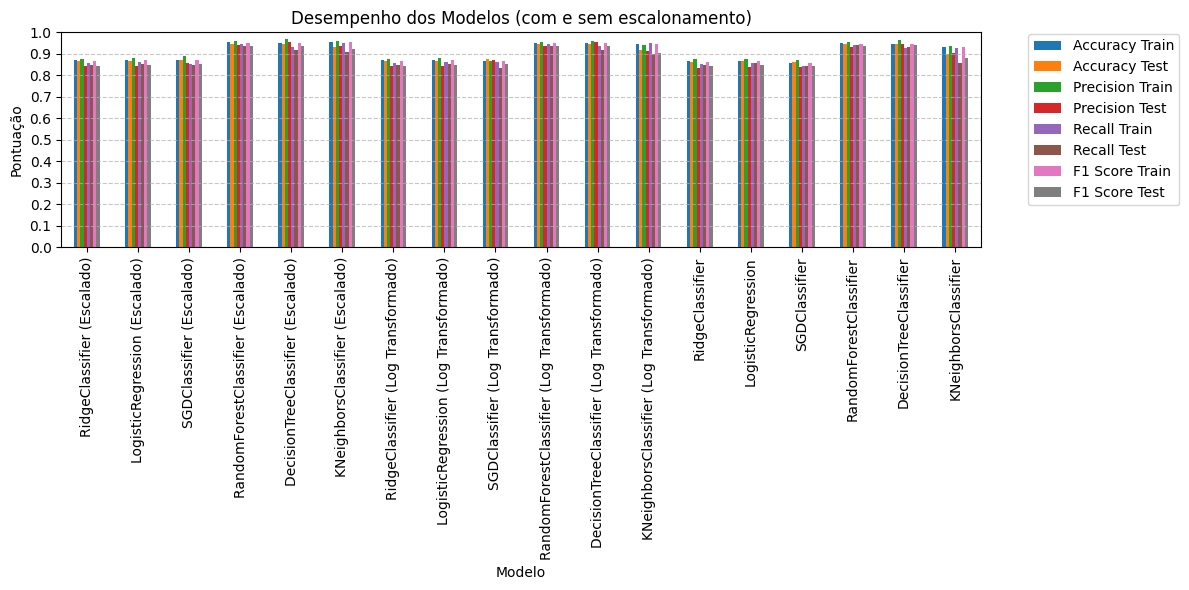

In [36]:
import matplotlib.ticker as ticker  # Importe para controlar as marcações do eixo

fig, ax = plt.subplots(figsize=(12, 6))
df_plot = df_resultados.set_index('Modelo')[[
    'Accuracy Train', 
    'Accuracy Test',
    'Precision Train',
    'Precision Test',
    'Recall Train', 
    'Recall Test',
    'F1 Score Train', 
    'F1 Score Test']]
df_plot.plot(kind='bar', ax=ax)

# Configurar marcações do eixo Y (passos de 0.1)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))  # Define intervalos de 0.1
ax.set_ylim(0, 1)  # Garante que o eixo Y vá de 0 a 1 (ajuste se necessário)

# Adicionar grid
ax.grid(True, axis='y', linestyle='--', alpha=0.7)  # Grid horizontal tracejado

# Ajustar legenda fora do gráfico
ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.1
)

plt.title('Desempenho dos Modelos (com e sem escalonamento)')
plt.ylabel('Pontuação')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [37]:
# Avaliação do melhor modelo
melhor_modelo = df_resultados.loc[df_resultados['F1 Score Test'].idxmax()]

print(f"Melhor modelo: {melhor_modelo['Modelo']}")
print(f"Melhor F1 Score: {melhor_modelo['F1 Score Test']}")
print(f"Melhores hiperparâmetros: {melhor_modelo['Melhores Hiperparâmetros']}")

modelo_final:DecisionTreeClassifier = melhor_modelo['Melhor Modelo']

# Exportando o melhor modelo
joblib.dump(modelo_final, 'melhor_modelo.pkl')

Melhor modelo: DecisionTreeClassifier
Melhor F1 Score: 0.9392633112346523
Melhores hiperparâmetros: OrderedDict({'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3, 'classifier__splitter': 'best'})


['melhor_modelo.pkl']

        Genero_Mulher  Tipo_Cliente_Cliente_Nao_Fiel  \
28817             1.0                            0.0   
39717             0.0                            0.0   
120220            1.0                            0.0   
47602             0.0                            0.0   
57721             1.0                            0.0   

        Tipo_Viagem_Viagem_Pessoal  Classe_Economica_Plus  Classe_Executivo  \
28817                          0.0                    0.0               1.0   
39717                          0.0                    0.0               1.0   
120220                         0.0                    0.0               1.0   
47602                          0.0                    0.0               1.0   
57721                          0.0                    0.0               1.0   

        Idade  Distancia_Voo  Wifi_Bordo  Horario_Conveniente  \
28817      46           2447           4                    4   
39717      30            320           2                  

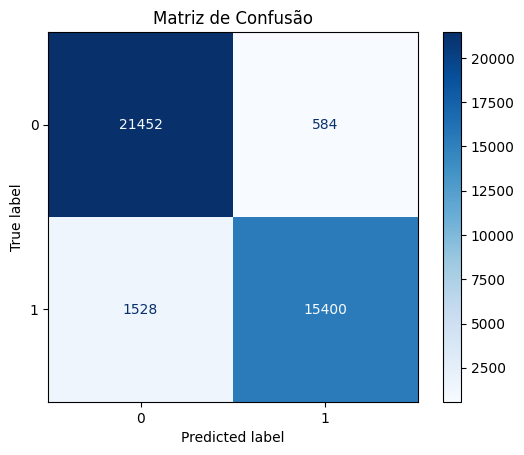

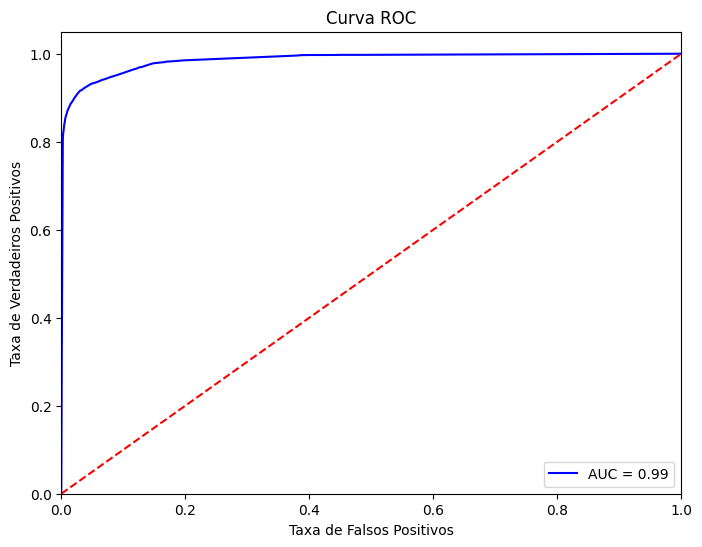

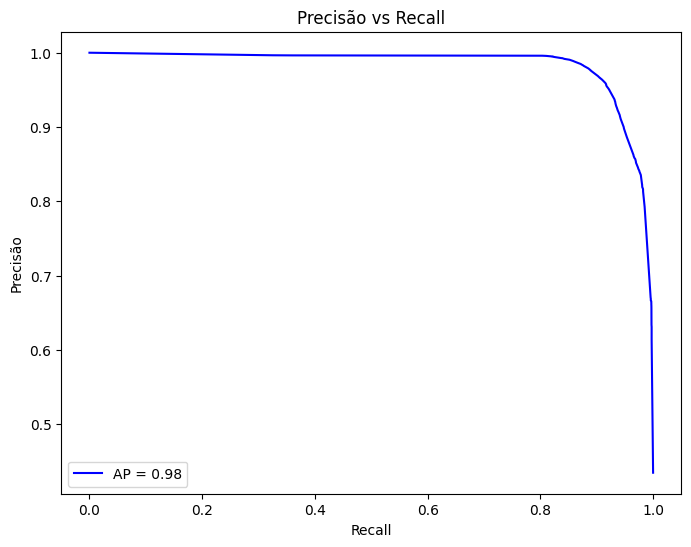

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import joblib

modelo_final = joblib.load('melhor_modelo.pkl')


X = df.drop('Satisfacao', axis=1)
y = df['Satisfacao']
y = y.map({'Neutro ou Insatisfeito': 0, 'Satisfeito': 1})
# result = acorr_ljungbox(y_pipeline.map({'Neutro ou Insatisfeito':0, 'Satisfeito': 1}), lags=5)
# print(result)  # Se p-valor > 0.05, não há autocorrelação


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

X_train = fazer_one_hot_encoding(X_train)
X_test = fazer_one_hot_encoding(X_test)
print(X_train.head())
print(X_train.shape)

X_train = remover_colunas(X_train)
X_test = remover_colunas(X_test)
print(X_train.head())
print(X_train.shape)

X_train = imputar_e_atualizar_dataframe(X_train)
X_test = imputar_e_atualizar_dataframe(X_test)
print(X_train.head())
print(X_train.shape)


def calcular_metricas(modelo, pipeline, X_train, X_test, y_train, y_test):
    # Transformar os dados usando o pipeline
    X_train_processed = pipeline.fit_transform(X_train)
    X_test_processed = pipeline.transform(X_test)
    
    # Fazer predições no conjunto de treino e teste
    y_pred_train = modelo.fit(X_train_processed, y_train).predict(X_train_processed)
    y_pred_test = modelo.predict(X_test_processed)
    
    # Calcular métricas
    print("Métricas no conjunto de treino:")
    print("Acurácia:", accuracy_score(y_train, y_pred_train))
    print("Precisão:", precision_score(y_train, y_pred_train))
    print("Recall:", recall_score(y_train, y_pred_train))
    print("F1 Score:", f1_score(y_train, y_pred_train))
    
    print("\nMétricas no conjunto de teste:")
    print("Acurácia:", accuracy_score(y_test, y_pred_test))
    print("Precisão:", precision_score(y_test, y_pred_test))
    print("Recall:", recall_score(y_test, y_pred_test))
    print("F1 Score:", f1_score(y_test, y_pred_test))
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão')
    plt.show()
    
    # Calcular ROC e Precisão vs Recall
    if hasattr(modelo, "decision_function"):
        y_scores = modelo.decision_function(X_test_processed)
    elif hasattr(modelo, "predict_proba"):
        y_scores = modelo.predict_proba(X_test_processed)[:, 1]
    else:
        raise ValueError("O modelo não suporta decision_function nem predict_proba.")
    
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()
    
    # Precisão vs Recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    average_precision = average_precision_score(y_test, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', label='AP = %0.2f' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precisão')
    plt.title('Precisão vs Recall')
    plt.legend(loc='lower left')
    plt.show()
    
calcular_metricas(modelo_final, pipeline_puro, X_train, X_test, y_train, y_test)